In [10]:
from Models import MostPopularRecommender, ItemKNN, MRFApprox, sparsify, sparsity_pattern_cov, DLAE, EDLAE, ADMM_EDLAE
import pandas as pd
import torch
import numpy as np

import matplotlib.pyplot as plt
import timeit
import time
import scipy.sparse as sp
from scipy.linalg import lu_solve
from copy import deepcopy
from bottleneck import argpartition
from sparse_dot_topn import awesome_cossim_topn


from scipy.linalg import lu_factor, lu_solve, cholesky, eigh
from scipy.linalg.lapack import spotri

from metrics import Recall, NDCG

# TODO

- MRF Grid search, benchmark
- ItemKNN search
- Matrix Factorization: Hyperparam Netflix, all Benchmarks, Research Question: speedup mit indirektem Loeser
- bei Sparsen Modellen: Wie ist der Zusammenhang Sparsity Pattern <-> Speed des MV-Produktes

# Note

This notebook does not contain any hyperparameter search. The sole purpose is reproduce the benchmark results for the already determined optimal hyperparameters.

# Data

In [2]:
def parse_data(data: pd.DataFrame, uid_str: str, sid_str: str, nItems):
        nUsers = len(data[uid_str].unique())
        users = data[uid_str].astype('category').cat.codes.values
        items = data[sid_str].values
        vals = np.ones(len(data))
        X = sp.csr_matrix((vals, (users, items)), shape=(nUsers, nItems), dtype=np.float32)
        return X

## ML20M

In [3]:
train_ML20M = pd.read_csv('/home/pmoritz/dev/modsem/data/ml-20m/train.csv')
val_tr_ML20M = pd.read_csv('/home/pmoritz/dev/modsem/data/ml-20m/validation_tr.csv')
val_te_ML20M = pd.read_csv('/home/pmoritz/dev/modsem/data/ml-20m/validation_te.csv')
test_tr_ML20M = pd.read_csv('/home/pmoritz/dev/modsem/data/ml-20m/test_tr.csv')
test_te_ML20M = pd.read_csv('/home/pmoritz/dev/modsem/data/ml-20m/test_te.csv')
metrics_lst = ['Recall(k=20)', 'Recall(k=50)', 'NDCG(k=100)',]

X_train_ML20M = parse_data(train_ML20M, uid_str='uid', sid_str='sid', nItems=len(train_ML20M.sid.unique()))
X_test_tr_ML20M = parse_data(test_tr_ML20M, uid_str='uid', sid_str='sid', nItems=len(train_ML20M.sid.unique()))
X_test_te_ML20M = parse_data(test_te_ML20M, uid_str='uid', sid_str='sid', nItems=len(train_ML20M.sid.unique()))

## Netflix

In [4]:
train_netflix = pd.read_csv('/home/pmoritz/dev/modsem/data/netflix/train.csv')
val_tr_netflix = pd.read_csv('/home/pmoritz/dev/modsem/data/netflix/validation_tr.csv')
val_te_netflix = pd.read_csv('/home/pmoritz/dev/modsem/data/netflix/validation_te.csv')
test_tr_netflix = pd.read_csv('/home/pmoritz/dev/modsem/data/netflix/test_tr.csv')
test_te_netflix = pd.read_csv('/home/pmoritz/dev/modsem/data/netflix/test_te.csv')
metrics_lst = ['Recall(k=20)', 'Recall(k=50)', 'NDCG(k=100)',]

X_train_netflix = parse_data(train_netflix, uid_str='uid', sid_str='sid', nItems=len(train_netflix.sid.unique()))
X_test_tr_netflix = parse_data(test_tr_netflix, uid_str='uid', sid_str='sid', nItems=len(train_netflix.sid.unique()))
X_test_te_netflix = parse_data(test_te_netflix, uid_str='uid', sid_str='sid', nItems=len(train_netflix.sid.unique()))

## MSD

In [5]:
train_msd = pd.read_csv('/home/pmoritz/dev/modsem/data/msd/train.csv')
val_tr_msd = pd.read_csv('/home/pmoritz/dev/modsem/data/msd/validation_tr.csv')
val_te_msd = pd.read_csv('/home/pmoritz/dev/modsem/data/msd/validation_te.csv')
test_tr_msd = pd.read_csv('/home/pmoritz/dev/modsem/data/msd/test_tr.csv')
test_te_msd = pd.read_csv('/home/pmoritz/dev/modsem/data/msd/test_te.csv')
metrics_lst = ['Recall(k=20)', 'Recall(k=50)', 'NDCG(k=100)',]

X_train_msd = parse_data(train_msd, uid_str='uid', sid_str='sid', nItems=len(train_msd.sid.unique()))
X_test_tr_msd = parse_data(test_tr_msd, uid_str='uid', sid_str='sid', nItems=len(train_msd.sid.unique()))
X_test_te_msd = parse_data(test_te_msd, uid_str='uid', sid_str='sid', nItems=len(train_msd.sid.unique()))

# Helper Functions

In [6]:
def timeit_dense(model_mat, X_test_tr, n_users_test, max_k = 100):
    rng = np.random.default_rng(seed=42)
    rand_batch_idx = rng.integers(low=0, high=n_users_test, size=1000)
    rand_query_idx = rng.integers(low=0, high=n_users_test, size=10)
    batch = X_test_tr[rand_batch_idx, :].toarray() # dense batch
    
    def pred_batch():
        pred = np.dot(batch, model_mat)
        pred[batch != 0.] = -np.inf
        pred_ind = argpartition(-pred, max_k-1, axis=1)[:, :max_k]

    timer = timeit.Timer(pred_batch)
    n_timer, _ = timer.autorange()
    batch_time = min(timer.repeat(repeat=7, number=n_timer)) / n_timer

    times, indexes = [], []
    for rand_int in rand_query_idx:
        query = X_test_tr[rand_int].toarray().reshape(1,-1)

        def pred_query():
            pred = np.dot(query, model_mat)
            pred[query != 0.] = -np.inf 
            max_ind = argpartition(-pred, max_k-1, axis=1)[:, :max_k]

        timer = timeit.Timer(pred_query)
        n_timer, _ = timer.autorange()
        query_time_run = min(timer.repeat(repeat=7, number=n_timer)) / n_timer

        times.append(query_time_run)
        indexes.append(rand_int)

    query_time = np.average(times) 
    return batch_time, query_time

In [7]:
def timeit_dense_lowrank(model_U, model_V, X_test_tr, n_users_test, max_k = 100):
    rng = np.random.default_rng(seed=42)
    rand_batch_idx = rng.integers(low=0, high=n_users_test, size=1000)
    rand_query_idx = rng.integers(low=0, high=n_users_test, size=10)
    batch = X_test_tr[rand_batch_idx, :].toarray() # dense batch
    
    def pred_batch():
        pred = np.dot( np.dot(batch, model_U), model_V.T)
        pred[batch != 0.] = -np.inf
        pred_ind = argpartition(-pred, max_k-1, axis=1)[:, :max_k]

    timer = timeit.Timer(pred_batch)
    n_timer, _ = timer.autorange()
    batch_time = min(timer.repeat(repeat=7, number=n_timer)) / n_timer

    times, indexes = [], []
    for rand_int in rand_query_idx:
        query = X_test_tr[rand_int].toarray().reshape(1,-1)

        def pred_query():
            pred = np.dot( np.dot(query, model_U), model_V.T)
            pred[query != 0.] = -np.inf 
            max_ind = argpartition(-pred, max_k-1, axis=1)[:, :max_k]

        timer = timeit.Timer(pred_query)
        n_timer, _ = timer.autorange()
        query_time_run = min(timer.repeat(repeat=7, number=n_timer)) / n_timer

        times.append(query_time_run)
        indexes.append(rand_int)

    query_time = np.average(times) 
    return batch_time, query_time

In [8]:
def timeit_dense_lusolve(model, X_test, n_users_test, max_k = 100):
    rng = np.random.default_rng(seed=42)
    rand_batch_idx = rng.integers(low=0, high=n_users_test, size=1000)
    rand_query_idx = rng.integers(low=0, high=n_users_test, size=10)
    batch = X_test[rand_batch_idx, :].toarray() # dense batch
    batch_T = batch.T
    
    def pred_batch():
        pred = (batch_T - lu_solve((model.lu, model.piv), batch_T)).T
        pred[batch != 0.] = -np.inf
        pred_ind = argpartition(-pred, max_k-1, axis=1)[:, :max_k]

    timer = timeit.Timer(pred_batch)
    n_timer, _ = timer.autorange()
    batch_time = min(timer.repeat(repeat=7, number=n_timer)) / n_timer

    times, indexes = [], []
    for rand_int in rand_query_idx:
        query = X_test[rand_int].toarray().reshape(1,-1)
        query_T = query.T

        def pred_query():
            pred = (query_T - lu_solve((model.lu, model.piv), query_T)).T
            pred[query != 0.] = -np.inf 
            max_ind = argpartition(-pred, max_k-1, axis=1)[:, :max_k]

        timer = timeit.Timer(pred_query)
        n_timer, _ = timer.autorange()
        query_time_run = min(timer.repeat(repeat=7, number=n_timer)) / n_timer

        times.append(query_time_run)
        indexes.append(rand_int)

    query_time = np.average(times) 
    return batch_time, query_time

In [9]:
def timeit_sparse(model_sparse, X_test, n_users_test, max_k = 100, n_jobs=16):
    """
    Suppa fast, using awesome_cossim_topn 
    """
    rng = np.random.default_rng(seed=42)
    rand_batch_idx = rng.integers(low=0, high=n_users_test, size=1000)
    rand_query_idx = rng.integers(low=0, high=n_users_test, size=10)
    batch = X_test[rand_batch_idx, :] #sparse batch
    sparse_id = sp.identity(model_sparse.shape[0], dtype=np.float32, format='csr')
    
    # need to define B this way, in order to remove the items with which the user interacted from the preds 
    # computed by awesome_cossim_topn
    B = model_sparse - np.inf * sparse_id
    
    def pred_batch():
        pred = awesome_cossim_topn(A=batch, B=B, ntop=max_k, use_threads=True, n_jobs=n_jobs).indices
        
    timer = timeit.Timer(pred_batch)
    n_timer, _ = timer.autorange()
    batch_time = min(timer.repeat(repeat=7, number=n_timer)) / n_timer
    
    times, indexes = [], []
    for rand_int in rand_query_idx:
        query = X_test[rand_int]
        
        def pred_query():
            pred = awesome_cossim_topn(A=query, B=B, ntop=max_k, use_threads=False, n_jobs=1).indices
        
        timer = timeit.Timer(pred_query)
        n_timer, _ = timer.autorange()
        query_time_run = min(timer.repeat(repeat=7, number=n_timer)) / n_timer
        
        times.append(query_time_run)
        indexes.append(rand_int)
        
    query_time = np.average(times) 
    return batch_time, query_time

In [10]:
def timeit_dense_VAE(model_best, device, X_test_tr, n_users_test, max_k = 100):
    model_best.to(device=device)
    model_best.eval()
    
    rng = np.random.default_rng(seed=42)
    rand_batch_idx = rng.integers(low=0, high=n_users_test, size=1000)
    rand_query_idx = rng.integers(low=0, high=n_users_test, size=10)
    batch = torch.Tensor(X_test_tr[rand_batch_idx, :].toarray()).to(device) # dense batch
    
    def pred_batch():
        pred = model_best(batch, calculate_loss=False).detach()
        pred[batch != 0.] = -torch.inf 
        _, max_ind = pred.topk(k=max_k, axis=1)

    timer = timeit.Timer(pred_batch)
    n_timer, _ = timer.autorange()
    batch_time = min(timer.repeat(repeat=7, number=n_timer)) / n_timer

    times, indexes = [], []
    for rand_int in rand_query_idx:
        query = torch.Tensor(X_test_tr[rand_int, :].toarray()).to(device)

        def pred_query():
            pred = model_best(query, calculate_loss=False).detach()
            pred[query != 0.] = -torch.inf 
            _, max_ind = pred.topk(k=max_k)

        timer = timeit.Timer(pred_query)
        n_timer, _ = timer.autorange()
        query_time_run = min(timer.repeat(repeat=7, number=n_timer)) / n_timer

        times.append(query_time_run)
        indexes.append(rand_int)

    query_time = np.average(times) 
    return batch_time, query_time

# Models

## Most Popular Recommender

### ML20M

In [9]:
model_pop = MostPopularRecommender(nItems=20108)
model_pop.fit(train_ML20M, uid_str='uid', sid_str='sid')
metr_pop = model_pop.evaluate_metrics(test_tr_ML20M, test_te_ML20M, 'uid', 'sid', metrics_lst)
print(f"Numpy Most-Popular: Recall@20: {metr_pop['Recall(k=20)']:.8f}, Recall@50: {metr_pop['Recall(k=50)']:.8f}, NDCG@100: {metr_pop['NDCG(k=100)']:.8f}")

create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Numpy Most-Popular: Recall@20: 0.16179511, Recall@50: 0.23519126, NDCG@100: 0.19055265


### Netflix

In [12]:
model_pop = MostPopularRecommender(nItems=17769)
model_pop.fit(train_netflix, uid_str='uid', sid_str='sid')
metr_pop = model_pop.evaluate_metrics(test_tr_netflix, test_te_netflix, 'uid', 'sid', metrics_lst)
print(f"Numpy Most-Popular: Recall@20: {metr_pop['Recall(k=20)']:.8f}, Recall@50: {metr_pop['Recall(k=50)']:.8f}, NDCG@100: {metr_pop['NDCG(k=100)']:.8f}")

create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Numpy Most-Popular: Recall@20: 0.11618164, Recall@50: 0.17488988, NDCG@100: 0.15873620


### MSD

In [13]:
model_pop = MostPopularRecommender(nItems=41140)
model_pop.fit(train_msd, uid_str='uid', sid_str='sid')
metr_pop = model_pop.evaluate_metrics(test_tr_msd, test_te_msd, 'uid', 'sid', metrics_lst)
print(f"Numpy Most-Popular: Recall@20: {metr_pop['Recall(k=20)']:.8f}, Recall@50: {metr_pop['Recall(k=50)']:.8f}, NDCG@100: {metr_pop['NDCG(k=100)']:.8f}")

create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Numpy Most-Popular: Recall@20: 0.04266630, Recall@50: 0.06805783, NDCG@100: 0.05821317


## ItemKNN

### ML20M

### Netflix

### MSD

## Matrix Factorization

## EDLAE
Using the Hyperparameters that were provided in the paper. The EDLAE model uses a fast inverse routine based on scipys LAPACK api. This directly exploits the definiteness of the model-matrix.

### ML20M

In [5]:
model_EDLAE = EDLAE(p=0.33, lmbda=300)
model_EDLAE.fit(train_ML20M, uid_str='uid', sid_str='sid', nItems=20108)
metr_EDLAE = model_EDLAE.evaluate_metrics(test_tr_ML20M, test_te_ML20M, 'uid', 'sid', metrics_lst)
print(f'My DLAE:  Recall@20: {metr_EDLAE["Recall(k=20)"]:.8f}, Recall@50: {metr_EDLAE["Recall(k=50)"]:.8f}, NDCG@100: {metr_EDLAE["NDCG(k=100)"]:.8f}')

finished inverse computation
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
My DLAE:  Recall@20: 0.39262427, Recall@50: 0.52320221, NDCG@100: 0.42414733


In [7]:
batch_time, query_time = timeit_dense(
                 model_mat = model_EDLAE.B,
                 X_test_tr = X_test_tr_ML20M, 
                 n_users_test = X_test_tr_ML20M.shape[0], 
                 max_k = 100)

print(f'Retrieval time for 1000 queries: {batch_time} sec, Average retrieval time for 1 query: {query_time} sec')

Retrieval time for 1000 queries: 1.024047702999951 sec, Average retrieval time for 1 query: 0.03804571812000404 sec


In [ ]:
# Retrieval time for 1000 queries: 1.6952928089995112 sec, Average retrieval time for 1 query: 0.04276158154003497 sec

### Netflix

In [9]:
model_EDLAE = EDLAE(p=0.33, lmbda=500)
model_EDLAE.fit(train_netflix, uid_str='uid', sid_str='sid', nItems=17769)
metr_EDLAE = model_EDLAE.evaluate_metrics(test_tr_netflix, test_te_netflix, 'uid', 'sid', metrics_lst)
print(f'My DLAE:  Recall@20: {metr_EDLAE["Recall(k=20)"]:.8f}, Recall@50: {metr_EDLAE["Recall(k=50)"]:.8f}, NDCG@100: {metr_EDLAE["NDCG(k=100)"]:.8f}')

finished inverse computation
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
My DLAE:  Recall@20: 0.36553381, Recall@50: 0.44917571, NDCG@100: 0.39768706


In [10]:
batch_time, query_time = timeit_dense(
                 model_mat = model_EDLAE.B,
                 X_test_tr = X_test_tr_netflix, 
                 n_users_test = X_test_tr_netflix.shape[0], 
                 max_k = 100)

print(f'Retrieval time for 1000 queries: {batch_time} sec, Average retrieval time for 1 query: {query_time} sec')

Retrieval time for 1000 queries: 0.974228961000108 sec, Average retrieval time for 1 query: 0.030050264259998582 sec


### MSD

In [15]:
model_EDLAE = EDLAE(p=0.25, lmbda=70)
model_EDLAE.fit(train_msd, uid_str='uid', sid_str='sid', nItems=41140)
metr_EDLAE = model_EDLAE.evaluate_metrics(test_tr_msd, test_te_msd, 'uid', 'sid', metrics_lst)
print(f'My DLAE:  Recall@20: {metr_EDLAE["Recall(k=20)"]:.8f}, Recall@50: {metr_EDLAE["Recall(k=50)"]:.8f}, NDCG@100: {metr_EDLAE["NDCG(k=100)"]:.8f}')

finished inverse computation
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
My DLAE:  Recall@20: 0.33407616, Recall@50: 0.42947739, NDCG@100: 0.39150817


In [16]:
batch_time, query_time = timeit_dense(
                 model_mat = model_EDLAE.B,
                 X_test_tr = X_test_tr_msd, 
                 n_users_test = X_test_tr_msd.shape[0], 
                 max_k = 100)

print(f'Retrieval time for 1000 queries: {batch_time} sec, Average retrieval time for 1 query: {query_time} sec')

Retrieval time for 1000 queries: 4.441371983999943 sec, Average retrieval time for 1 query: 0.18684247719993435 sec


In [ ]:
# Retrieval time for 1000 queries: 6.8957461810000495 sec, Average retrieval time for 1 query: 0.2051606809999953 sec

## DLAE

### ML20M

In [17]:
model_DLAE = DLAE(p=0.33, lmbda=300, method='chol')
model_DLAE.fit(train_ML20M, uid_str='uid', sid_str='sid', nItems=20108)
metr_DLAE = model_DLAE.evaluate_metrics(test_tr_ML20M, test_te_ML20M, 'uid', 'sid', metrics_lst)
print(f'My EASE:  Recall@20: {metr_DLAE["Recall(k=20)"]:.8f}, Recall@50: {metr_DLAE["Recall(k=50)"]:.8f}, NDCG@100: {metr_DLAE["NDCG(k=100)"]:.8f}')

create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
My EASE:  Recall@20: 0.39083883, Recall@50: 0.52222514, NDCG@100: 0.42242085


In [18]:
batch_time, query_time = timeit_dense_lusolve(
                 model = model_DLAE,
                 X_test = model_DLAE.X_test, 
                 n_users_test = model_DLAE.X_test.shape[0], 
                 max_k = 100)

print(f'Retrieval time for 1000 queries: {batch_time} sec, Average retrieval time for 1 query: {query_time} sec')

Retrieval time for 1000 queries: 1.4158661910000774 sec, Average retrieval time for 1 query: 0.04428897712001344 sec


### Netflix

In [21]:
model_DLAE = DLAE(p=0.33, lmbda=500, method='chol')
model_DLAE.fit(train_netflix, uid_str='uid', sid_str='sid', nItems=17769)
metr_DLAE = model_DLAE.evaluate_metrics(test_tr_netflix, test_te_netflix, 'uid', 'sid', metrics_lst)
print(f'My EASE:  Recall@20: {metr_DLAE["Recall(k=20)"]:.8f}, Recall@50: {metr_DLAE["Recall(k=50)"]:.8f}, NDCG@100: {metr_DLAE["NDCG(k=100)"]:.8f}')

create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
My EASE:  Recall@20: 0.36200935, Recall@50: 0.44547859, NDCG@100: 0.39470801


In [22]:
batch_time, query_time = timeit_dense_lusolve(
                 model = model_DLAE,
                 X_test = model_DLAE.X_test, 
                 n_users_test = model_DLAE.X_test.shape[0], 
                 max_k = 100)

print(f'Retrieval time for 1000 queries: {batch_time} sec, Average retrieval time for 1 query: {query_time} sec')

Retrieval time for 1000 queries: 1.1066707749996567 sec, Average retrieval time for 1 query: 0.033927167649994774 sec


### MSD

In [23]:
model_DLAE = DLAE(p=0.25, lmbda=70, method='chol')
model_DLAE.fit(train_msd, uid_str='uid', sid_str='sid', nItems=41140)
metr_DLAE = model_DLAE.evaluate_metrics(test_tr_msd, test_te_msd, 'uid', 'sid', metrics_lst)
print(f'My EASE:  Recall@20: {metr_DLAE["Recall(k=20)"]:.8f}, Recall@50: {metr_DLAE["Recall(k=50)"]:.8f}, NDCG@100: {metr_DLAE["NDCG(k=100)"]:.8f}')

create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
My EASE:  Recall@20: 0.32671274, Recall@50: 0.42409090, NDCG@100: 0.38436593


In [ ]:
batch_time, query_time = timeit_dense_lusolve(
                 model = model_DLAE,
                 X_test = model_DLAE.X_test, 
                 n_users_test = model_DLAE.X_test.shape[0], 
                 max_k = 100)

print(f'Retrieval time for 1000 queries: {batch_time} sec, Average retrieval time for 1 query: {query_time} sec')

## EDLAE Low-Rank

In [9]:
def run_lowrank_benchmark(path_to_BWV, result_path, X_test_tr, fitted_model, result_metrics, test_tr, test_te, k_vec = [10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000]):
    batch_times, query_times = [], []
    recalls20, recalls50, ndcgs100 = [], [], []

    batch_time, query_time = timeit_dense(
                     model_mat = fitted_model.B,
                     X_test_tr = X_test_tr, 
                     n_users_test = X_test_tr.shape[0], 
                     max_k = 100)

    batch_times.append(batch_time)
    query_times.append(query_time)
    recalls20.append(result_metrics["Recall(k=20)"])
    recalls50.append(result_metrics["Recall(k=50)"])
    ndcgs100.append(result_metrics["NDCG(k=100)"])
    
    B = np.load(file=f'{path_to_BWV}/B.npy',)
    W = np.load(file=f'{path_to_BWV}/W.npy',)
    V = np.load(file=f'{path_to_BWV}/V.npy',)

    for k in k_vec:
        print(f'Current {k}')
        V_k = V[:, -k:]
        U_k = np.dot(B, V_k)
        batch_time, query_time = timeit_dense_lowrank(model_U=U_k, model_V=V_k, X_test_tr=X_test_tr, n_users_test=X_test_tr.shape[0], max_k = 100)

        fitted_model.B = np.dot(U_k, V_k.T)
        metr_EDLAE = fitted_model.evaluate_metrics(test_tr, test_te, 'uid', 'sid', metrics=['Recall(k=20)', 'Recall(k=50)', 'NDCG(k=100)',])

        batch_times.append(batch_time)
        query_times.append(query_time)
        recalls20.append(metr_EDLAE["Recall(k=20)"])
        recalls50.append(metr_EDLAE["Recall(k=50)"])
        ndcgs100.append(metr_EDLAE["NDCG(k=100)"])
        
    results = pd.DataFrame(
                 {'k': [fitted_model.nItems] + k_vec,
                  'Recall@20': recalls20,
                  'Recall@50': recalls50,
                  'NDCG@100': ndcgs100,
                  'query time': query_times,
                  'batch time': batch_times,})
    results.to_csv(result_path, index=False)

### ML20M

#### Eigendecomposition

In [7]:
model_EDLAE = EDLAE(p=0.33, lmbda=300)
model_EDLAE.fit(train_ML20M, uid_str='uid', sid_str='sid', nItems=20108, store_G_inv=True)
metr_EDLAE = model_EDLAE.evaluate_metrics(test_tr_ML20M, test_te_ML20M, 'uid', 'sid', metrics_lst)
print(f'My EDLAE:  Recall@20: {metr_EDLAE["Recall(k=20)"]:.8f}, Recall@50: {metr_EDLAE["Recall(k=50)"]:.8f}, NDCG@100: {metr_EDLAE["NDCG(k=100)"]:.8f}')

finished inverse computation
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
My EDLAE:  Recall@20: 0.39262427, Recall@50: 0.52320221, NDCG@100: 0.42414733


In [10]:
M = model_EDLAE.B.T @ model_EDLAE.G_inv @ model_EDLAE.B
W, V = eigh(M, driver='evd')

np.save(file='EDLAE_mat/ml20m/B.npy', arr=model_EDLAE.B)
np.save(file='EDLAE_mat/ml20m/G_inv.npy', arr=model_EDLAE.G_inv)
np.save(file='EDLAE_mat/ml20m/W.npy', arr=W)
np.save(file='EDLAE_mat/ml20m/V.npy', arr=V)

#### Benchmark

In [10]:
run_lowrank_benchmark(path_to_BWV='EDLAE_mat/ml20m', result_path='/home/pmoritz/dev/modsem/benchmarks/ml20m_lowrank.csv', 
                      X_test_tr=X_test_tr_ML20M, 
                      fitted_model=model_EDLAE, 
                      result_metrics=metr_EDLAE, 
                      test_tr=test_tr_ML20M, 
                      test_te=test_te_ML20M, 
                      k_vec = [10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000])

Current 10
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Current 20
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Current 50
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Current 100
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Current 200
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Current 500
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Current 1000
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Current 2000
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Current 5000
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Current 10000
create lookup
create true item df
predict

### Netflix

#### Eigendecomposition

In [14]:
model_EDLAE = EDLAE(p=0.33, lmbda=500)
model_EDLAE.fit(train_netflix, uid_str='uid', sid_str='sid', nItems=17769, store_G_inv=True)
metr_EDLAE = model_EDLAE.evaluate_metrics(test_tr_netflix, test_te_netflix, 'uid', 'sid', metrics_lst)
print(f'My DLAE:  Recall@20: {metr_EDLAE["Recall(k=20)"]:.8f}, Recall@50: {metr_EDLAE["Recall(k=50)"]:.8f}, NDCG@100: {metr_EDLAE["NDCG(k=100)"]:.8f}')

finished inverse computation
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
My DLAE:  Recall@20: 0.36553381, Recall@50: 0.44917571, NDCG@100: 0.39768706


In [6]:
M = model_EDLAE.B.T @ model_EDLAE.G_inv @ model_EDLAE.B
W, V = eigh(M, driver='evd')

np.save(file='EDLAE_mat/netflix/B.npy', arr=model_EDLAE.B)
np.save(file='EDLAE_mat/netflix/G_inv.npy', arr=model_EDLAE.G_inv)
np.save(file='EDLAE_mat/netflix/W.npy', arr=W)
np.save(file='EDLAE_mat/netflix/V.npy', arr=V)

#### Benchmark

In [15]:
run_lowrank_benchmark(path_to_BWV='EDLAE_mat/netflix', result_path='/home/pmoritz/dev/modsem/benchmarks/netflix_lowrank.csv', 
                      X_test_tr=X_test_tr_netflix, 
                      fitted_model=model_EDLAE, 
                      result_metrics=metr_EDLAE, 
                      test_tr=test_tr_netflix, 
                      test_te=test_te_netflix, 
                      k_vec = [10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 15000])

Current 10
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Current 20
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Current 50
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Current 100
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Current 200
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Current 500
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Current 1000
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Current 2000
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Current 5000
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Current 10000
create lookup
create true item df
predict

### MSD

#### Eigendecomposition

In [16]:
model_EDLAE = EDLAE(p=0.25, lmbda=70)
model_EDLAE.fit(train_msd, uid_str='uid', sid_str='sid', nItems=41140, store_G_inv=True)
metr_EDLAE = model_EDLAE.evaluate_metrics(test_tr_msd, test_te_msd, 'uid', 'sid', metrics_lst)
print(f'My DLAE:  Recall@20: {metr_EDLAE["Recall(k=20)"]:.8f}, Recall@50: {metr_EDLAE["Recall(k=50)"]:.8f}, NDCG@100: {metr_EDLAE["NDCG(k=100)"]:.8f}')

finished inverse computation
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
My DLAE:  Recall@20: 0.33407616, Recall@50: 0.42947739, NDCG@100: 0.39150817


In [5]:
M = model_EDLAE.B.T @ model_EDLAE.G_inv @ model_EDLAE.B
W, V = eigh(M, driver='ev')

np.save(file='EDLAE_mat/msd/B.npy', arr=model_EDLAE.B)
np.save(file='EDLAE_mat/msd/G_inv.npy', arr=model_EDLAE.G_inv)
np.save(file='EDLAE_mat/msd/W.npy', arr=W)
np.save(file='EDLAE_mat/msd/V.npy', arr=V)

#### Benchmark

In [17]:
run_lowrank_benchmark(path_to_BWV='EDLAE_mat/msd', result_path='/home/pmoritz/dev/modsem/benchmarks/msd_lowrank.csv', 
                      X_test_tr=X_test_tr_msd, 
                      fitted_model=model_EDLAE, 
                      result_metrics=metr_EDLAE, 
                      test_tr=test_tr_msd, 
                      test_te=test_te_msd, 
                      k_vec = [10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000, 30000])

Current 10
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Current 20
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Current 50
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Current 100
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Current 200
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Current 500
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Current 1000
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Current 2000
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Current 5000
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Current 10000
create lookup
create true item df
predict

### Plot of the results

In [ ]:
results_lowrank_ML20 = pd.read_csv('/home/pmoritz/dev/modsem/benchmarks/ml20m_lowrank.csv')
results_lowrank_netflix = pd.read_csv('/home/pmoritz/dev/modsem/benchmarks/netflix_lowrank.csv')
results_lowrank_msd = pd.read_csv('/home/pmoritz/dev/modsem/benchmarks/msd_lowrank.csv')

results_lowrank_ML20.sort_values(by='k', inplace=True)
results_lowrank_netflix.sort_values(by='k', inplace=True)
results_lowrank_msd.sort_values(by='k', inplace=True)

results_lowrank_ML20.reset_index(drop=True, inplace=True)
results_lowrank_netflix.reset_index(drop=True, inplace=True)
results_lowrank_msd.reset_index(drop=True, inplace=True)

fig, ax = plt.subplots(2, 3, figsize=(30, 20))
ax[1, 2].set_visible(False)

ax[1, 0].set_position([0.24,0.125,0.228,0.343])
ax[1, 1].set_position([0.55,0.125,0.228,0.343])

ax[0, 0].plot(results_lowrank_ML20.k, results_lowrank_ML20['Recall@20'], marker='o', label='Recall@20')
ax[0, 0].plot(results_lowrank_ML20.k, results_lowrank_ML20['Recall@50'], marker='o', label='Recall@50')
ax[0, 0].plot(results_lowrank_ML20.k, results_lowrank_ML20['NDCG@100'], marker='o', label='NDCG@100')
ax[0, 0].set_xlabel('Rank k')
ax[0, 0].set_ylabel('Metrics')
ax[0, 0].set_xscale('log')
ax[0, 0].set_title('MovieLens20M \nItems: 20,108, Users: 136,677, Interactions: 10M')
ax[0, 0].legend()

ax[0, 1].plot(results_lowrank_netflix.k, results_lowrank_netflix['Recall@20'], marker='o', label='Recall@20')
ax[0, 1].plot(results_lowrank_netflix.k, results_lowrank_netflix['Recall@50'], marker='o', label='Recall@50')
ax[0, 1].plot(results_lowrank_netflix.k, results_lowrank_netflix['NDCG@100'], marker='o', label='NDCG@100')
ax[0, 1].set_xlabel('Rank k')
ax[0, 1].set_ylabel('Metrics')
ax[0, 1].set_xscale('log')
ax[0, 1].set_title('Netflix Prize \nItems: 17,769, Users: 463,435, Interactions: 57M')
ax[0, 1].legend()

ax[0, 2].plot(results_lowrank_msd.k, results_lowrank_msd['Recall@20'], marker='o', label='Recall@20')
ax[0, 2].plot(results_lowrank_msd.k, results_lowrank_msd['Recall@50'], marker='o', label='Recall@50')
ax[0, 2].plot(results_lowrank_msd.k, results_lowrank_msd['NDCG@100'], marker='o', label='NDCG@100')
ax[0, 2].set_xlabel('Rank k')
ax[0, 2].set_ylabel('Metrics')
ax[0, 2].set_xscale('log')
ax[0, 2].set_title('Million Songs \nItems: 41,140, Users: 571,355, Interactions: 34M')
ax[0, 2].legend()

ax[1, 0].plot(results_lowrank_ML20.k, results_lowrank_ML20['query time'], marker='o', label='ML20M')
ax[1, 0].plot(results_lowrank_netflix.k, results_lowrank_netflix['query time'], marker='o', label='Netflix')
ax[1, 0].plot(results_lowrank_msd.k, results_lowrank_msd['query time'], marker='o', label='MSD')
ax[1, 0].set_xlabel('Rank k')
ax[1, 0].set_ylabel('Time [s]')
ax[1, 0].set_xscale('log')
ax[1, 0].set_yscale('log')
ax[1, 0].set_title('Prediction time for one query')
ax[1, 0].legend()

ax[1, 1].plot(results_lowrank_ML20.k, results_lowrank_ML20['batch time'], marker='o', label='ML20M')
ax[1, 1].plot(results_lowrank_netflix.k, results_lowrank_netflix['batch time'], marker='o', label='Netflix')
ax[1, 1].plot(results_lowrank_msd.k, results_lowrank_msd['batch time'], marker='o', label='MSD')
ax[1, 1].set_xlabel('Rank k')
ax[1, 1].set_ylabel('Time [s]')
ax[1, 1].set_xscale('log')
ax[1, 1].set_yscale('log')
ax[1, 1].set_title('Prediction time for 1000 queries')
ax[1, 1].legend()

plt.figtext(0.5, 0.07, "The datapoint with the largest value of k is the full-rank model.", ha="center", fontsize=14,);

## EDLAE Sparse

#### Example

In [9]:
model_EDLAE = EDLAE(p=0.33, lmbda=300)
model_EDLAE.fit(train_ML20M, uid_str='uid', sid_str='sid', nItems=20108)
metr_EDLAE = model_EDLAE.evaluate_metrics(test_tr_ML20M, test_te_ML20M, 'uid', 'sid', metrics_lst)
print(f'My EDLAE:  Recall@20: {metr_EDLAE["Recall(k=20)"]:.8f}, Recall@50: {metr_EDLAE["Recall(k=50)"]:.8f}, NDCG@100: {metr_EDLAE["NDCG(k=100)"]:.8f}')

finished inverse computation
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
My EDLAE:  Recall@20: 0.39262427, Recall@50: 0.52320221, NDCG@100: 0.42414733


In [10]:
model_EDLAE.B = sparsify(model_EDLAE.B, threshold=0.00704, max_in_col=20108)
model_EDLAE.B = model_EDLAE.B.toarray()
metr_EDLAE = model_EDLAE.evaluate_metrics(test_tr_ML20M, test_te_ML20M, 'uid', 'sid', metrics_lst)
print(f'My EDLAE:  Recall@20: {metr_EDLAE["Recall(k=20)"]:.8f}, Recall@50: {metr_EDLAE["Recall(k=50)"]:.8f}, NDCG@100: {metr_EDLAE["NDCG(k=100)"]:.8f}')

Number of items with more than 20108 entries in column: 0
Resulting sparsity of A: 0.004983465752016889
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
My EDLAE:  Recall@20: 0.38448743, Recall@50: 0.50804613, NDCG@100: 0.41366124


In [11]:
B_csr = sp.csr_matrix(model_EDLAE.B)

#### Test if the stuff used in run_sparse_straightforward_benchmark actually works

In [68]:
from metrics import Recall, NDCG
from sparse_dot_topn import awesome_cossim_topn

In [81]:
model_EDLAE = EDLAE(p=0.33, lmbda=300)
model_EDLAE.fit(train_ML20M, uid_str='uid', sid_str='sid', nItems=20108)
model_EDLAE.B = sparsify(model_EDLAE.B, threshold=0.00704, max_in_col=20108)
B_csr = sp.csr_matrix(deepcopy(model_EDLAE.B))

sparse_id = sp.identity(B_csr.shape[0], dtype=np.float32, format='csr')
B_csr_thilde = B_csr - np.inf * sparse_id

finished inverse computation
Number of items with more than 20108 entries in column: 0
Resulting sparsity of A: 0.004983465752016889


In [82]:
top_k = awesome_cossim_topn(A=X_test_tr_ML20M, B=B_csr_thilde, ntop=100, use_threads=True, n_jobs=16)

In [83]:
recall20 = Recall(k=20)
recall50 = Recall(k=50)
ndcg100 = NDCG(k=100)

recall20_metr, recall50_metr, ndcg100_metr = [], [], []
for row_idx in range(X_test_tr_ML20M.shape[0]):
    pred_items = top_k[row_idx].indices
    true_items = X_test_te_ML20M[row_idx].indices
    
    recall20_metr.append(recall20(pred_items, true_items))
    recall50_metr.append(recall50(pred_items, true_items))
    ndcg100_metr.append(ndcg100(pred_items, true_items))

In [84]:
np.mean(recall20_metr), np.mean(recall50_metr), np.mean(ndcg100_metr)

(0.38448743230840365, 0.5080461290209418, 0.4136612334564698)

### Sparse Straightforward

In [11]:
def run_sparse_straightforward_benchmark(result_path, X_test_tr, fitted_model, test_tr, test_te, sparsity_threshold, max_in_col):
    model_mat = deepcopy(fitted_model.B)
    
    sparsities, thresholds = [], []
    batch_times, query_times = [], []
    recall20, recall50, ndcg100 = [], [], []

    for sparsity in sparsity_threshold:
        print(f'Current Sparsity: {sparsity}')
        threshold = sparsity_threshold[sparsity]
        A = sparsify(model_mat, threshold=threshold, max_in_col=max_in_col)
        fitted_model.B = np.zeros(model_mat.shape, dtype=np.float32)
        fitted_model.B[A.nonzero()] = model_mat[A.nonzero()]
        calc_sparsity = len(A.nonzero()[0]) / (fitted_model.B.shape[0] * fitted_model.B.shape[1])

        batch_time, query_time = timeit_sparse(model_sparse = sp.csr_matrix(fitted_model.B), 
                                               X_test = X_test_tr, 
                                               n_users_test = X_test_tr.shape[0], max_k = 100)

        metr_EDLAE = fitted_model.evaluate_metrics(test_tr, test_te, 'uid', 'sid', metrics=['Recall(k=20)', 'Recall(k=50)', 'NDCG(k=100)',])

        sparsities.append(calc_sparsity)
        thresholds.append(threshold)
        batch_times.append(batch_time)
        query_times.append(query_time)
        recall20.append(metr_EDLAE["Recall(k=20)"])
        recall50.append(metr_EDLAE["Recall(k=50)"])
        ndcg100.append(metr_EDLAE["NDCG(k=100)"])

    results = pd.DataFrame({'sparsity': sparsities,
                           'threshold': thresholds,
                           'query_time': query_times, 
                           'batch_time': batch_times,
                           'recall@20': recall20,
                           'recall@50': recall50,
                           'ndcg@100': ndcg100,})
    results.to_csv(result_path, index=False, sep='|')    

#### ML20M

In [85]:
!pwd

/home/pmoritz/dev/modsem


In [86]:
sparsity_threshold_ml20m = {0.1: 0.0122,
                            0.5: 0.00704,
                            1.0: 0.00522,
                            2.0: 0.00366,
                            5.0: 0.00208}

model_EDLAE = EDLAE(p=0.33, lmbda=300)
model_EDLAE.fit(train_ML20M, uid_str='uid', sid_str='sid', nItems=20108)

finished inverse computation


In [103]:
run_sparse_straightforward_benchmark(result_path='/home/pmoritz/dev/modsem/benchmarks/ml20m_sparse_straightforward_new.csv', 
                                     X_test_tr=X_test_tr_ML20M, 
                                     fitted_model=model_EDLAE, 
                                     test_tr=test_tr_ML20M, 
                                     test_te=test_te_ML20M, 
                                     sparsity_threshold=sparsity_threshold_ml20m, 
                                     max_in_col=model_EDLAE.B.shape[0])

Current Sparsity: 0.1
Number of items with more than 20108 entries in column: 0
Resulting sparsity of A: 0.000995952174549456
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Current Sparsity: 0.5
Number of items with more than 20108 entries in column: 0
Resulting sparsity of A: 0.004983465752016889
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Current Sparsity: 1.0
Number of items with more than 20108 entries in column: 0
Resulting sparsity of A: 0.009972528394412365
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Current Sparsity: 2.0
Number of items with more than 20108 entries in column: 0
Resulting sparsity of A: 0.01997733227244849
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Current Sparsity: 5.0
Number of items with more than 20108 entries in column: 0
Resulting sparsity of A: 0.049846672409015184

In [34]:
results_straightf_ml20m = pd.read_csv('/home/pmoritz/dev/modsem/benchmarks/ml20m_sparse_straightforward_new.csv', sep='|')

In [35]:
results_straightf_ml20m

,sparsity,threshold,query_time,batch_time,recall@20,recall@50,ndcg@100
0,0.000996,0.01220,0.000038,0.002182,0.371671,0.493390,0.402077
1,0.004983,0.00704,0.000043,0.003903,0.384487,0.508046,0.413661
2,0.009973,0.00522,0.000049,0.005279,0.388080,0.513011,0.417549
3,0.019977,0.00366,0.000054,0.007732,0.390239,0.518839,0.420696
4,0.049847,0.00208,0.000077,0.013323,0.391565,0.522446,0.423361


#### Netflix

In [16]:
sparsity_threshold_netflix = {0.1: 0.0129,
                           0.5: 0.00791,
                           1.0: 0.00621,
                           2.0: 0.00467,
                           5.0: 0.00292}

model_EDLAE = EDLAE(p=0.33, lmbda=500)
model_EDLAE.fit(train_netflix, uid_str='uid', sid_str='sid', nItems=17769)

finished inverse computation


In [17]:
run_sparse_straightforward_benchmark(result_path='/home/pmoritz/dev/modsem/benchmarks/netflix_sparse_straightforward_new.csv', 
                                     X_test_tr=X_test_tr_netflix, 
                                     fitted_model=model_EDLAE, 
                                     test_tr=test_tr_netflix, 
                                     test_te=test_te_netflix, 
                                     sparsity_threshold=sparsity_threshold_netflix, 
                                     max_in_col=model_EDLAE.B.shape[0])

Current Sparsity: 0.1
Number of items with more than 17769 entries in column: 0
Resulting sparsity of A: 0.000991643811199144
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Current Sparsity: 0.5
Number of items with more than 17769 entries in column: 0
Resulting sparsity of A: 0.004982394212131266
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Current Sparsity: 1.0
Number of items with more than 17769 entries in column: 0
Resulting sparsity of A: 0.009967857430720718
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Current Sparsity: 2.0
Number of items with more than 17769 entries in column: 0
Resulting sparsity of A: 0.01999267676149355
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Current Sparsity: 5.0
Number of items with more than 17769 entries in column: 0
Resulting sparsity of A: 0.04977902504227239


In [20]:
results_straightf_netflix = pd.read_csv('/home/pmoritz/dev/modsem/benchmarks/netflix_sparse_straightforward_new.csv', sep='|')

In [21]:
results_straightf_netflix

,sparsity,threshold,query_time,batch_time,recall@20,recall@50,ndcg@100
0,0.000992,0.01290,0.000037,0.002497,0.344885,0.424491,0.376210
1,0.004982,0.00791,0.000041,0.003970,0.352183,0.434613,0.385183
2,0.009968,0.00621,0.000044,0.005168,0.355969,0.438597,0.388261
3,0.019993,0.00467,0.000049,0.006928,0.359929,0.442264,0.391517
4,0.049779,0.00292,0.000061,0.011384,0.363344,0.446394,0.395190


#### MSD

In [9]:
sparsity_threshold_msd = {0.1: 0.0120,
                          0.5: 0.00695,
                          1.0: 0.00548,
                          2.0: 0.00421,
                          5.0: 0.00285}

model_EDLAE = EDLAE(p=0.25, lmbda=70)
model_EDLAE.fit(train_msd, uid_str='uid', sid_str='sid', nItems=41140)

finished inverse computation


In [10]:
run_sparse_straightforward_benchmark(result_path='/home/pmoritz/dev/modsem/benchmarks/msd_sparse_straightforward_new.csv', 
                                     X_test_tr=X_test_tr_msd, 
                                     fitted_model=model_EDLAE, 
                                     test_tr=test_tr_msd, 
                                     test_te=test_te_msd, 
                                     sparsity_threshold=sparsity_threshold_msd, 
                                     max_in_col=model_EDLAE.B.shape[0])

Current Sparsity: 0.1
Number of items with more than 41140 entries in column: 0
Resulting sparsity of A: 0.0009962667051738152
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Current Sparsity: 0.5
Number of items with more than 41140 entries in column: 0
Resulting sparsity of A: 0.004999415657173567
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Current Sparsity: 1.0
Number of items with more than 41140 entries in column: 0
Resulting sparsity of A: 0.009965166313776381
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Current Sparsity: 2.0
Number of items with more than 41140 entries in column: 0
Resulting sparsity of A: 0.019910698354079374
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Current Sparsity: 5.0
Number of items with more than 41140 entries in column: 0
Resulting sparsity of A: 0.0498602032165916

In [11]:
results_straightf_msd = pd.read_csv('/home/pmoritz/dev/modsem/benchmarks/msd_sparse_straightforward_new.csv', sep='|')

In [12]:
results_straightf_msd

,sparsity,threshold,query_time,batch_time,recall@20,recall@50,ndcg@100
0,0.000996,0.01200,0.000046,0.002143,0.329580,0.421199,0.385550
1,0.004999,0.00695,0.000061,0.005023,0.332307,0.425618,0.388885
2,0.009965,0.00548,0.000084,0.007808,0.332764,0.426840,0.389641
3,0.019911,0.00421,0.000122,0.012880,0.333207,0.427856,0.390281
4,0.049860,0.00285,0.000236,0.025263,0.333736,0.428533,0.390753


### Covariance Based

In [10]:
def run_sparse_cov_benchmark(result_path, X_train, X_test_tr, fitted_model, test_tr, test_te, sparsity_threshold, max_in_col):
    model_mat = deepcopy(fitted_model.B)
    XtX = np.dot(X_train.T, X_train)
    
    sparsities, thresholds, alphas = [], [], []
    batch_times, query_times = [], []
    recall20, recall50, ndcg100 = [], [], []

    for sparsity, thresh_alpha in sparsity_threshold.items():
        threshold, alpha = thresh_alpha
        print(f'Current Sparsity: {sparsity}')
        A = sparsity_pattern_cov(XtX=deepcopy(XtX.toarray()), n_users=X_train.shape[0], 
                                 max_in_col=max_in_col, alpha=alpha, threshold=threshold)
        fitted_model.B = np.zeros(model_mat.shape, dtype=np.float32)
        fitted_model.B[A.nonzero()] = model_mat[A.nonzero()]
        calc_sparsity = len(A.nonzero()[0]) / (fitted_model.B.shape[0] * fitted_model.B.shape[1])

        batch_time, query_time = timeit_sparse(model_sparse = sp.csr_matrix(fitted_model.B), 
                                               X_test = X_test_tr, 
                                               n_users_test = X_test_tr.shape[0], max_k = 100)
        #print(len(fitted_model.B.nonzero()[0]))
        #print(fitted_model.evaluate_metrics(test_tr, test_te, 'uid', 'sid', metrics=['Recall(k=20)', 'Recall(k=50)', 'NDCG(k=100)',]))
        res_metrics = fitted_model.evaluate_metrics(test_tr, test_te, 'uid', 'sid', metrics=['Recall(k=20)', 'Recall(k=50)', 'NDCG(k=100)',])
        print(f'Metrics:  Recall@20: {res_metrics["Recall(k=20)"]:.8f}, Recall@50: {res_metrics["Recall(k=50)"]:.8f}, NDCG@100: {res_metrics["NDCG(k=100)"]:.8f}')

        sparsities.append(calc_sparsity)
        thresholds.append(threshold)
        alphas.append(alpha)
        batch_times.append(batch_time)
        query_times.append(query_time)
        recall20.append(float(res_metrics["Recall(k=20)"]))
        recall50.append(float(res_metrics["Recall(k=50)"]))
        ndcg100.append(float(res_metrics["NDCG(k=100)"]))

    results = pd.DataFrame({'sparsity': sparsities,
                           'threshold': thresholds,
                           'alphas': alphas,
                           'query_time': query_times, 
                           'batch_time': batch_times,
                           'recall@20': recall20,
                           'recall@50': recall50,
                           'ndcg@100': ndcg100,})
    results.to_csv(result_path, index=False, sep='|')    

#### ML20M

In [29]:
hyperparam_search_ml20m = pd.read_csv(f'hyperparam_search/sparse_cov_ml20m.csv', sep='|')
hyperparam_search_ml20m['sum'] = hyperparam_search_ml20m['recall@20'] + hyperparam_search_ml20m['recall@50'] + hyperparam_search_ml20m['ndcg@100']

In [30]:
hyperparam_search_ml20m[hyperparam_search_ml20m.sparsity == 5.0].sort_values(by='sum', ascending=False)

,sparsity,threshold,alpha,recall@20,recall@50,ndcg@100,sum
16,5.0,1.6900,0.25,0.397238,0.524413,0.431641,1.353292
17,5.0,0.4480,0.50,0.397157,0.524133,0.431338,1.352628
18,5.0,0.1340,0.75,0.397297,0.523887,0.430737,1.351921
19,5.0,0.0399,1.00,0.394128,0.520827,0.428902,1.343857


In [31]:
sparsity_threshold_ml20m = {0.1: [6.580, 0.5],
                            0.5: [2.64, 0.5],
                            1.0: [9.23, 0.25],
                            2.0: [4.73, 0.25],
                            5.0: [1.69, 0.25]}

model_EDLAE = EDLAE(p=0.33, lmbda=300)
model_EDLAE.fit(train_ML20M, uid_str='uid', sid_str='sid', nItems=20108)

finished inverse computation


In [32]:
run_sparse_cov_benchmark(result_path='/home/pmoritz/dev/modsem/benchmarks/ml20m_sparse_cov_new.csv',  
                                     X_train=X_train_ML20M, 
                                     X_test_tr=X_test_tr_ML20M, 
                                     fitted_model=model_EDLAE, 
                                     test_tr=test_tr_ML20M, 
                                     test_te=test_te_ML20M, 
                                     sparsity_threshold=sparsity_threshold_ml20m, 
                                     max_in_col=model_EDLAE.B.shape[0])

Current Sparsity: 0.1
Number of items with more than 20108 entries in column: 0
Resulting sparsity of A: 0.0009986652937475607
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Metrics:  Recall@20: 0.37513973, Recall@50: 0.49318726, NDCG@100: 0.40111827
Current Sparsity: 0.5
Number of items with more than 20108 entries in column: 0
Resulting sparsity of A: 0.004979679256581795
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Metrics:  Recall@20: 0.38730758, Recall@50: 0.51593067, NDCG@100: 0.41853007
Current Sparsity: 1.0
Number of items with more than 20108 entries in column: 0
Resulting sparsity of A: 0.009999751095427441
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Metrics:  Recall@20: 0.39019983, Recall@50: 0.52001396, NDCG@100: 0.42119253
Current Sparsity: 2.0
Number of items with more than 20108 entries in column: 0
Resulting sparsity of A: 0.0199

In [33]:
results_sparsecov_ml20m = pd.read_csv('/home/pmoritz/dev/modsem/benchmarks/ml20m_sparse_cov_new.csv', sep='|')

In [34]:
results_sparsecov_ml20m

,sparsity,threshold,alphas,query_time,batch_time,recall@20,recall@50,ndcg@100
0,0.000999,6.58,0.50,0.000050,0.005312,0.375140,0.493187,0.401118
1,0.004980,2.64,0.50,0.000071,0.012431,0.387308,0.515931,0.418530
2,0.010000,9.23,0.25,0.000096,0.019320,0.390200,0.520014,0.421193
3,0.019968,4.73,0.25,0.000124,0.028070,0.391896,0.522009,0.422832
4,0.049844,1.69,0.25,0.000200,0.045912,0.392272,0.522881,0.423813


#### Netflix

In [19]:
hyperparam_search_netflix = pd.read_csv(f'hyperparam_search/sparse_cov_nflx.csv', sep='|')
hyperparam_search_netflix['sum'] = hyperparam_search_netflix['recall@20'] + hyperparam_search_netflix['recall@50'] + hyperparam_search_netflix['ndcg@100']

In [20]:
hyperparam_search_netflix[hyperparam_search_netflix.sparsity == 5.0].sort_values(by='sum', ascending=False)

,sparsity,threshold,alpha,recall@20,recall@50,ndcg@100,sum
17,5.0,1.764,0.50,0.364429,0.447388,0.396615,1.208432
18,5.0,0.260,0.75,0.364342,0.447346,0.396594,1.208281
16,5.0,12.420,0.25,0.364464,0.447053,0.396440,1.207958
19,5.0,0.043,1.00,0.363820,0.446956,0.396069,1.206845


In [25]:
sparsity_threshold_netflix = {0.1: [2.047, 0.75],
                              0.5: [1.096, 0.75],
                              1.0: [0.772, 0.75],
                              2.0: [0.509, 0.75],
                              5.0: [1.764, 0.5]}

model_EDLAE = EDLAE(p=0.33, lmbda=500)
model_EDLAE.fit(train_netflix, uid_str='uid', sid_str='sid', nItems=17769)

finished inverse computation


In [26]:
run_sparse_cov_benchmark(result_path='/home/pmoritz/dev/modsem/benchmarks/netlix_sparse_cov_new.csv',  
                                     X_train=X_train_netflix, 
                                     X_test_tr=X_test_tr_netflix, 
                                     fitted_model=model_EDLAE, 
                                     test_tr=test_tr_netflix, 
                                     test_te=test_te_netflix, 
                                     sparsity_threshold=sparsity_threshold_netflix, 
                                     max_in_col=model_EDLAE.B.shape[0])

Current Sparsity: 0.1
Number of items with more than 17769 entries in column: 0
Resulting sparsity of A: 0.000999688472090574
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Metrics:  Recall@20: 0.34568683, Recall@50: 0.42337809, NDCG@100: 0.37511258
Current Sparsity: 0.5
Number of items with more than 17769 entries in column: 0
Resulting sparsity of A: 0.004997865931995296
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Metrics:  Recall@20: 0.35978085, Recall@50: 0.44187559, NDCG@100: 0.39129279
Current Sparsity: 1.0
Number of items with more than 17769 entries in column: 0
Resulting sparsity of A: 0.00998490641086976
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Metrics:  Recall@20: 0.36267501, Recall@50: 0.44593750, NDCG@100: 0.39481643
Current Sparsity: 2.0
Number of items with more than 17769 entries in column: 0
Resulting sparsity of A: 0.019980

In [27]:
results_sparsecov_netflix = pd.read_csv('/home/pmoritz/dev/modsem/benchmarks/netlix_sparse_cov_new.csv', sep='|')

In [28]:
results_sparsecov_netflix

,sparsity,threshold,alphas,query_time,batch_time,recall@20,recall@50,ndcg@100
0,0.001000,2.047,0.75,0.000054,0.005387,0.345687,0.423378,0.375113
1,0.004998,1.096,0.75,0.000087,0.013377,0.359781,0.441876,0.391293
2,0.009985,0.772,0.75,0.000113,0.019967,0.362675,0.445938,0.394816
3,0.019981,0.509,0.75,0.000153,0.029651,0.364439,0.448163,0.396702
4,0.049920,1.764,0.50,0.000265,0.055286,0.365214,0.449104,0.397588


#### MSD

In [11]:
hyperparam_search_msd = pd.read_csv(f'hyperparam_search/sparse_cov_msd.csv', sep='|')
hyperparam_search_msd['sum'] = hyperparam_search_msd['recall@20'] + hyperparam_search_msd['recall@50'] + hyperparam_search_msd['ndcg@100']

In [12]:
hyperparam_search_msd[hyperparam_search_msd.sparsity == 0.1].sort_values(by='sum', ascending=False)

,sparsity,threshold,alpha,recall@20,recall@50,ndcg@100,sum
2,0.1,0.3700,0.75,0.327127,0.419308,0.382858,1.129293
1,0.1,2.0500,0.50,0.327066,0.419205,0.382677,1.128947
3,0.1,0.0704,1.00,0.326425,0.417829,0.381624,1.125878
0,0.1,12.0400,0.25,0.325377,0.416370,0.380646,1.122393


In [13]:
sparsity_threshold_msd = {0.1: [0.37, 0.75],
                          0.5: [0.609, 0.50],
                          1.0: [0.399, 0.50],
                          2.0: [0.0511, 0.75],
                          5.0: [0.00644, 1.0]}

model_EDLAE = EDLAE(p=0.25, lmbda=70)
model_EDLAE.fit(train_msd, uid_str='uid', sid_str='sid', nItems=41140)

finished inverse computation


In [14]:
run_sparse_cov_benchmark(result_path='/home/pmoritz/dev/modsem/benchmarks/msd_sparse_cov_new.csv',  
                                     X_train=X_train_msd, 
                                     X_test_tr=X_test_tr_msd, 
                                     fitted_model=model_EDLAE, 
                                     test_tr=test_tr_msd, 
                                     test_te=test_te_msd, 
                                     sparsity_threshold=sparsity_threshold_msd, 
                                     max_in_col=model_EDLAE.B.shape[0])

Current Sparsity: 0.1
Number of items with more than 41140 entries in column: 0
Resulting sparsity of A: 0.0009994832495085965
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Metrics:  Recall@20: 0.32876085, Recall@50: 0.41958407, NDCG@100: 0.38431205
Current Sparsity: 0.5
Number of items with more than 41140 entries in column: 0
Resulting sparsity of A: 0.00499654889135572
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Metrics:  Recall@20: 0.33315223, Recall@50: 0.42782471, NDCG@100: 0.39051469
Current Sparsity: 1.0
Number of items with more than 41140 entries in column: 0
Resulting sparsity of A: 0.009994196158155666
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Metrics:  Recall@20: 0.33353189, Recall@50: 0.42922019, NDCG@100: 0.39124441
Current Sparsity: 2.0
Number of items with more than 41140 entries in column: 0
Resulting sparsity of A: 0.01999

In [15]:
results_sparsecov_msd = pd.read_csv('/home/pmoritz/dev/modsem/benchmarks/msd_sparse_cov_new.csv', sep='|')

In [16]:
results_sparsecov_msd

,sparsity,threshold,alphas,query_time,batch_time,recall@20,recall@50,ndcg@100
0,0.000999,0.37000,0.75,0.000056,0.003136,0.328761,0.419584,0.384312
1,0.004997,0.60900,0.50,0.000156,0.014406,0.333152,0.427825,0.390515
2,0.009994,0.39900,0.50,0.000271,0.024603,0.333532,0.429220,0.391244
3,0.019999,0.05110,0.75,0.000345,0.032637,0.333932,0.429746,0.391716
4,0.049976,0.00644,1.00,0.000490,0.048523,0.334155,0.429881,0.391885


## ADMM Slim

### ML20M

#### Sparsity 0.5%

In [14]:
res = pd.read_csv('/home/pmoritz/dev/modsem/hyperparam_search/hyperparam_search_SLIM_ml20m_05_100epoch_part4.csv', sep='|')
res['sum'] = res['Recall@20'] + res['Recall@50'] + res['NDCG@100']
res.sort_values(by='sum')

,Recall@20,Recall@50,NDCG@100,lambda2,rho,lambda1,sparsity,primal norm,dual norm,eps primal,eps dual,sum
17,0.395977,0.522786,0.429802,100,1000,10.674,0.500036,0.032085,1.131068,0.021307,2.732413,1.348565
14,0.395973,0.522876,0.429895,100,800,10.597,0.499714,0.041746,1.152021,0.021309,2.705414,1.348744
11,0.396187,0.522881,0.429913,100,650,10.511,0.499400,0.052986,1.168467,0.021311,2.677414,1.348982
8,0.396364,0.522854,0.429988,100,500,10.378,0.499058,0.071500,1.265299,0.021315,2.637467,1.349207
16,0.396260,0.523131,0.430143,10,1000,10.674,0.487082,0.031761,1.318336,0.021450,2.711821,1.349534
5,0.396554,0.522903,0.430095,100,300,9.995,0.500068,0.129172,1.575584,0.021325,2.537735,1.349551
12,0.396205,0.523204,0.430195,0,800,10.597,0.485175,0.041203,1.436471,0.021481,2.682358,1.349604
13,0.396188,0.523229,0.430237,10,800,10.597,0.486773,0.041267,1.207110,0.021453,2.685077,1.349655
15,0.396262,0.523224,0.430178,0,1000,10.674,0.485472,0.031718,1.955548,0.021478,2.709080,1.349664
9,0.396251,0.523172,0.430248,0,650,10.511,0.484890,0.052233,1.283055,0.021485,2.654690,1.349671


In [8]:
model_ADMM_EDLAE = ADMM_EDLAE(lambda1=9.4, lambda2=10, p=0.33, rho=200, eps_rel=0.0001, eps_abs=0.000001, tau=2, t=10)
final_sparsity, R_primal_norm, R_dual_norm, eps_primal, eps_dual = model_ADMM_EDLAE.fit(train_ML20M, 'uid', 'sid', 20108, check_convergence=True, adjust_rho=False, n_iter=100, return_info=True)
metr_dict = model_ADMM_EDLAE.evaluate_metrics(test_tr_ML20M, test_te_ML20M, 'uid', 'sid', metrics_lst)

Starting iteration 0
Current Sparsity:0.002%
Primal Residual Norm: 28.551044464111328, eps Primal: 0.02301251679229736
Dual Residual Norm: 690.9571647644043, eps Dual: 0.5911350019531251
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Starting iteration 1
Current Sparsity:0.010%
Primal Residual Norm: 16.595741271972656, eps Primal: 0.021947922142028807
Dual Residual Norm: 974.726390838623, eps Dual: 0.8999373945312501
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Starting iteration 2


KeyboardInterrupt: 

In [16]:
metr_dict

{'Recall(k=20)': 0.39226986579081347,
 'Recall(k=50)': 0.5217241022201276,
 'NDCG(k=100)': 0.42264110692414125}

In [17]:
timeit_sparse(sp.csr_matrix(model_ADMM_EDLAE.C), X_test=X_test_tr_ML20M, n_users_test=X_test_tr_ML20M.shape[0], max_k = 100, n_jobs=16)

(0.011709010449703783, 7.130735830010962e-05)

In [18]:
np.save(file='/home/pmoritz/dev/modsem/sparse_mat/' + 'ADMM_ml20m_05', arr=model_ADMM_EDLAE.C)

#### Sparsity 0.1%

In [19]:
res = pd.read_csv('/home/pmoritz/dev/modsem/hyperparam_search/hyperparam_search_SLIM_ml20m_01_100epoch_part2.csv', sep='|')
res['sum'] = res['Recall@20'] + res['Recall@50'] + res['NDCG@100']
res.sort_values(by='sum')

,Recall@20,Recall@50,NDCG@100,lambda2,rho,lambda1,sparsity,primal norm,dual norm,eps primal,eps dual,sum
17,0.386155,0.509544,0.420023,100,1000,40.29,0.102686,0.120966,3.755181,0.020996,5.306395,1.315722
16,0.386590,0.509666,0.420389,10,1000,40.29,0.100875,0.120352,3.807933,0.021043,5.281767,1.316646
14,0.386577,0.509711,0.420407,100,800,38.94,0.103289,0.151230,3.808599,0.021002,5.103034,1.316695
15,0.386563,0.509680,0.420473,0,1000,40.29,0.100658,0.120280,3.799656,0.021049,5.278837,1.316715
11,0.386895,0.509868,0.420610,100,650,37.97,0.102573,0.186397,3.792635,0.021006,4.932624,1.317372
13,0.386801,0.510032,0.420719,10,800,38.94,0.101447,0.150354,3.875206,0.021050,5.079174,1.317552
12,0.386782,0.510147,0.420793,0,800,38.94,0.101230,0.150251,3.886202,0.021057,5.076328,1.317722
10,0.386834,0.510048,0.420991,10,650,37.97,0.100755,0.185204,3.812402,0.021055,4.909637,1.317872
9,0.386822,0.510140,0.421021,0,650,37.97,0.100545,0.185062,3.810229,0.021062,4.906887,1.317983
8,0.387159,0.510083,0.420941,100,500,36.52,0.101843,0.241054,3.909089,0.021012,4.703737,1.318182


In [20]:
model_ADMM_EDLAE = ADMM_EDLAE(lambda1=29.54, lambda2=10, p=0.33, rho=200, eps_rel=0.0001, eps_abs=0.000001, tau=2, t=10)
final_sparsity, R_primal_norm, R_dual_norm, eps_primal, eps_dual = model_ADMM_EDLAE.fit(train_ML20M, 'uid', 'sid', 20108, check_convergence=True, adjust_rho=False, n_iter=100, return_info=True)
metr_dict = model_ADMM_EDLAE.evaluate_metrics(test_tr_ML20M, test_te_ML20M, 'uid', 'sid', metrics_lst)

Starting iteration 0
Current Sparsity:0.000%
Primal Residual Norm: 28.970413208007812, eps Primal: 0.02301251679229736
Dual Residual Norm: 183.28065872192383, eps Dual: 0.5995194257812501
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Starting iteration 1
Current Sparsity:0.000%
Primal Residual Norm: 17.62369155883789, eps Primal: 0.021917449958801266
Dual Residual Norm: 609.9852561950684, eps Dual: 0.9298198164062501
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Starting iteration 2
Current Sparsity:0.001%
Primal Residual Norm: 13.403881072998047, eps Primal: 0.021551015575408932
Dual Residual Norm: 487.16206550598145, eps Dual: 1.17023075390625
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Starting iteration 3
Current Sparsity:0.002%
Primal Residual Norm: 11.03476333618164, eps Primal: 0.021373026664733882
Dual Residual Norm: 415.7623767852783, eps Dual: 1.36223231640625
+

In [21]:
metr_dict

{'Recall(k=20)': 0.38429536546528814,
 'Recall(k=50)': 0.5117968961862935,
 'NDCG(k=100)': 0.41470931145713796}

In [22]:
timeit_sparse(sp.csr_matrix(model_ADMM_EDLAE.C), X_test=X_test_tr_ML20M, n_users_test=X_test_tr_ML20M.shape[0], max_k = 100, n_jobs=16)

(0.004849780020012986, 4.809655201999703e-05)

In [23]:
np.save(file='/home/pmoritz/dev/modsem/sparse_mat/' + 'ADMM_ml20m_01', arr=model_ADMM_EDLAE.C)

### Netflix

#### Sparsity 0.5%

In [24]:
res = pd.read_csv('/home/pmoritz/dev/modsem/hyperparam_search/hyperparam_search_SLIM_netflix_05_100epoch_part2.csv', sep='|')
res['sum'] = res['Recall@20'] + res['Recall@50'] + res['NDCG@100']
res.sort_values(by='sum')

,Recall@20,Recall@50,NDCG@100,lambda2,rho,lambda1,sparsity,primal norm,dual norm,eps primal,eps dual,sum
17,0.362453,0.444298,0.394354,100,1000,44.40,0.503841,0.235235,9.605478,0.019476,9.884852,1.201104
16,0.362645,0.444462,0.394441,10,1000,44.40,0.499421,0.233755,9.684440,0.019560,9.850985,1.201548
15,0.362660,0.444525,0.394466,0,1000,44.40,0.498911,0.233579,9.702779,0.019572,9.846971,1.201651
14,0.362664,0.444594,0.394508,100,800,42.30,0.504630,0.294764,10.484141,0.019486,9.423507,1.201766
13,0.362774,0.444669,0.394668,10,800,42.30,0.500184,0.292895,10.430719,0.019573,9.392757,1.202112
11,0.362720,0.444775,0.394666,100,650,40.03,0.508465,0.360973,11.122497,0.019499,8.965727,1.202160
12,0.362756,0.444733,0.394681,0,800,42.30,0.499673,0.292673,10.420841,0.019586,9.389109,1.202170
10,0.362910,0.444888,0.394812,10,650,40.03,0.503972,0.358727,11.049777,0.019589,8.935871,1.202610
8,0.362755,0.445036,0.394826,100,500,37.63,0.503677,0.469794,12.032629,0.019512,8.419698,1.202617
9,0.362921,0.444943,0.394838,0,650,40.03,0.503470,0.358463,11.045733,0.019602,8.932304,1.202702


In [25]:
model_ADMM_EDLAE = ADMM_EDLAE(lambda1=27.80, lambda2=0, p=0.33, rho=200, eps_rel=0.0001, eps_abs=0.000001, tau=2, t=10)
final_sparsity, R_primal_norm, R_dual_norm, eps_primal, eps_dual = model_ADMM_EDLAE.fit(train_netflix, 'uid', 'sid', 17769, check_convergence=True, adjust_rho=False, n_iter=100, return_info=True)
metr_dict = model_ADMM_EDLAE.evaluate_metrics(test_tr_netflix, test_te_netflix, 'uid', 'sid', metrics_lst)

Starting iteration 0
Current Sparsity:0.001%
Primal Residual Norm: 41.354164123535156, eps Primal: 0.02197297834777832
Dual Residual Norm: 778.0642986297607, eps Dual: 0.8447979062500001
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Starting iteration 1
Current Sparsity:0.003%
Primal Residual Norm: 25.733295440673828, eps Primal: 0.02060788339996338
Dual Residual Norm: 1666.1262512207031, eps Dual: 1.324269390625
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Starting iteration 2
Current Sparsity:0.006%
Primal Residual Norm: 19.85420036315918, eps Primal: 0.020207112258911135
Dual Residual Norm: 994.3149566650391, eps Dual: 1.678497515625
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Starting iteration 3
Current Sparsity:0.009%
Primal Residual Norm: 16.566713333129883, eps Primal: 0.020025547355651856
Dual Residual Norm: 705.8422565460205, eps Dual: 1.966681890625
++++++++++

In [26]:
metr_dict

{'Recall(k=20)': 0.36454960255560515,
 'Recall(k=50)': 0.44807026705527253,
 'NDCG(k=100)': 0.3967389039744398}

In [27]:
timeit_sparse(sp.csr_matrix(model_ADMM_EDLAE.C), X_test=X_test_tr_netflix, n_users_test=X_test_tr_netflix.shape[0], max_k = 100, n_jobs=16)

(0.009462311620009132, 6.655635586081189e-05)

In [28]:
np.save(file='/home/pmoritz/dev/modsem/sparse_mat/' + 'ADMM_netflix_05', arr=model_ADMM_EDLAE.C)

#### Sparsity 0.1%

In [29]:
res = pd.read_csv('/home/pmoritz/dev/modsem/hyperparam_search/hyperparam_search_SLIM_netflix_01_100epoch_part2.csv', sep='|')
res['sum'] = res['Recall@20'] + res['Recall@50'] + res['NDCG@100']
res.sort_values(by='sum')

,Recall@20,Recall@50,NDCG@100,lambda2,rho,lambda1,sparsity,primal norm,dual norm,eps primal,eps dual,sum
17,0.353160,0.432368,0.384191,100,1000,165.00,0.100072,0.698553,26.563698,0.019079,18.561589,1.169719
16,0.353384,0.432505,0.384312,10,1000,165.00,0.099542,0.696524,26.554145,0.019108,18.530033,1.170201
15,0.353382,0.432533,0.384316,0,1000,165.00,0.099484,0.696295,26.558079,0.019112,18.526411,1.170231
14,0.353542,0.432810,0.384621,100,800,150.00,0.100941,0.820014,26.467896,0.019104,16.901735,1.170973
13,0.353741,0.433022,0.384696,10,800,150.00,0.100391,0.817505,26.379398,0.019135,16.872980,1.171458
12,0.353732,0.433049,0.384715,0,800,150.00,0.100331,0.817219,26.389310,0.019139,16.869683,1.171497
11,0.353906,0.433162,0.384835,100,650,137.74,0.100475,0.954171,26.544772,0.019125,15.497910,1.171903
10,0.354057,0.433385,0.384925,10,650,137.74,0.099935,0.951114,26.826935,0.019159,15.471947,1.172366
9,0.354039,0.433392,0.384938,0,650,137.74,0.099872,0.950768,26.846227,0.019163,15.468955,1.172369
8,0.354260,0.433732,0.385086,100,500,122.12,0.100392,1.145761,27.035948,0.019155,13.805921,1.173079


In [30]:
model_ADMM_EDLAE = ADMM_EDLAE(lambda1=75.94, lambda2=0, p=0.33, rho=200, eps_rel=0.0001, eps_abs=0.000001, tau=2, t=10)
final_sparsity, R_primal_norm, R_dual_norm, eps_primal, eps_dual = model_ADMM_EDLAE.fit(train_netflix, 'uid', 'sid', 17769, check_convergence=True, adjust_rho=False, n_iter=100, return_info=True)
metr_dict = model_ADMM_EDLAE.evaluate_metrics(test_tr_netflix, test_te_netflix, 'uid', 'sid', metrics_lst)

Starting iteration 0
Current Sparsity:0.000%
Primal Residual Norm: 42.0366325378418, eps Primal: 0.02197297834777832
Dual Residual Norm: 22.382277250289917, eps Dual: 0.85844644140625
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Starting iteration 1
Current Sparsity:0.000%
Primal Residual Norm: 27.55567741394043, eps Primal: 0.020583121437072756
Dual Residual Norm: 775.7424354553223, eps Dual: 1.3798559140625
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Starting iteration 2
Current Sparsity:0.001%
Primal Residual Norm: 21.66269874572754, eps Primal: 0.020098130172729493
Dual Residual Norm: 1075.577449798584, eps Dual: 1.7714100156250001
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Starting iteration 3
Current Sparsity:0.001%
Primal Residual Norm: 18.36591911315918, eps Primal: 0.019861027473449706
Dual Residual Norm: 753.9731502532959, eps Dual: 2.0947699765625
+++++++++

In [31]:
metr_dict

{'Recall(k=20)': 0.3555992226211047,
 'Recall(k=50)': 0.43775692117864984,
 'NDCG(k=100)': 0.38712490919675174}

In [32]:
timeit_sparse(sp.csr_matrix(model_ADMM_EDLAE.C), X_test=X_test_tr_netflix, n_users_test=X_test_tr_netflix.shape[0], max_k = 100, n_jobs=16)

(0.0043238201198983, 4.604400443975465e-05)

In [33]:
np.save(file='/home/pmoritz/dev/modsem/sparse_mat/' + 'ADMM_netflix_01', arr=model_ADMM_EDLAE.C)

In [40]:
!pwd

/home/pmoritz/dev/modsem


## Comparision of the Sparsity Patterns

### ML20M

In [11]:
model_EDLAE = EDLAE(p=0.33, lmbda=300)
model_EDLAE.fit(train_ML20M, uid_str='uid', sid_str='sid', nItems=20108)
metr_EDLAE = model_EDLAE.evaluate_metrics(test_tr_ML20M, test_te_ML20M, 'uid', 'sid', metrics_lst)
print(f'My DLAE:  Recall@20: {metr_EDLAE["Recall(k=20)"]:.8f}, Recall@50: {metr_EDLAE["Recall(k=50)"]:.8f}, NDCG@100: {metr_EDLAE["NDCG(k=100)"]:.8f}')

finished inverse computation
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
My DLAE:  Recall@20: 0.39262427, Recall@50: 0.52320221, NDCG@100: 0.42414733


In [12]:
B_dense = deepcopy(model_EDLAE.B)

#### Sparsity 0.5%

In [13]:
results_straightf_ml20m = pd.read_csv('/home/pmoritz/dev/modsem/benchmarks/ml20m_sparse_straightforward_new.csv', sep='|')
results_sparsecov_ml20m = pd.read_csv('/home/pmoritz/dev/modsem/benchmarks/ml20m_sparse_cov_new.csv', sep='|')

In [14]:
results_straightf_ml20m

,sparsity,threshold,query_time,batch_time,recall@20,recall@50,ndcg@100
0,0.000996,0.01220,0.000038,0.002182,0.371671,0.493390,0.402077
1,0.004983,0.00704,0.000043,0.003903,0.384487,0.508046,0.413661
2,0.009973,0.00522,0.000049,0.005279,0.388080,0.513011,0.417549
3,0.019977,0.00366,0.000054,0.007732,0.390239,0.518839,0.420696
4,0.049847,0.00208,0.000077,0.013323,0.391565,0.522446,0.423361


In [15]:
results_sparsecov_ml20m

,sparsity,threshold,alphas,query_time,batch_time,recall@20,recall@50,ndcg@100
0,0.000999,6.58,0.50,0.000050,0.005312,0.375140,0.493187,0.401118
1,0.004980,2.64,0.50,0.000071,0.012431,0.387308,0.515931,0.418530
2,0.010000,9.23,0.25,0.000096,0.019320,0.390200,0.520014,0.421193
3,0.019968,4.73,0.25,0.000124,0.028070,0.391896,0.522009,0.422832
4,0.049844,1.69,0.25,0.000200,0.045912,0.392272,0.522881,0.423813


In [16]:
A_straightforward = sparsify(B_dense, threshold=0.00704, max_in_col=20108)
B_straightforward = np.zeros(B_dense.shape, dtype=np.float32)
B_straightforward[A_straightforward.nonzero()] = B_dense[A_straightforward.nonzero()]

Number of items with more than 20108 entries in column: 0
Resulting sparsity of A: 0.004983465752016889


In [17]:
model_EDLAE.B = B_straightforward
metr_EDLAE_straight = model_EDLAE.evaluate_metrics(test_tr_ML20M, test_te_ML20M, 'uid', 'sid', metrics_lst)
print(f'My EDLAE:  Recall@20: {metr_EDLAE_straight["Recall(k=20)"]:.8f}, Recall@50: {metr_EDLAE_straight["Recall(k=50)"]:.8f}, NDCG@100: {metr_EDLAE_straight["NDCG(k=100)"]:.8f}')

create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
My EDLAE:  Recall@20: 0.38448743, Recall@50: 0.50804613, NDCG@100: 0.41366124


In [31]:
times_straightforward = timeit_sparse(sp.csr_matrix(B_straightforward), X_test=X_test_tr_ML20M, n_users_test=X_test_tr_ML20M.shape[0], max_k = 100, n_jobs=16)

In [19]:
A_sparsecov = sparsity_pattern_cov(XtX=np.dot(X_train_ML20M.T, X_train_ML20M).toarray(), n_users=X_train_ML20M.shape[0], 
                                 max_in_col=20108, alpha=0.50, threshold=2.64)
B_cov = np.zeros(B_dense.shape, dtype=np.float32)
B_cov[A_sparsecov.nonzero()] = B_dense[A_sparsecov.nonzero()]

Number of items with more than 20108 entries in column: 0
Resulting sparsity of A: 0.004979679256581795


In [20]:
model_EDLAE.B = B_cov
metr_EDLAE_cov = model_EDLAE.evaluate_metrics(test_tr_ML20M, test_te_ML20M, 'uid', 'sid', metrics_lst)
print(f'My EDLAE:  Recall@20: {metr_EDLAE_cov["Recall(k=20)"]:.8f}, Recall@50: {metr_EDLAE_cov["Recall(k=50)"]:.8f}, NDCG@100: {metr_EDLAE_cov["NDCG(k=100)"]:.8f}')

create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
My EDLAE:  Recall@20: 0.38730758, Recall@50: 0.51593067, NDCG@100: 0.41853007


In [32]:
times_cov = timeit_sparse(sp.csr_matrix(B_cov), X_test=X_test_tr_ML20M, n_users_test=X_test_tr_ML20M.shape[0], max_k = 100, n_jobs=16)

In [22]:
B_admm = np.load(file='/home/pmoritz/dev/modsem/sparse_mat/' + 'ADMM_ml20m_05.npy')

In [23]:
model_EDLAE.B = B_admm
metr_EDLAE_admm = model_EDLAE.evaluate_metrics(test_tr_ML20M, test_te_ML20M, 'uid', 'sid', metrics_lst)
print(f'My EDLAE:  Recall@20: {metr_EDLAE_admm["Recall(k=20)"]:.8f}, Recall@50: {metr_EDLAE_admm["Recall(k=50)"]:.8f}, NDCG@100: {metr_EDLAE_admm["NDCG(k=100)"]:.8f}')

create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
My EDLAE:  Recall@20: 0.39226987, Recall@50: 0.52172410, NDCG@100: 0.42264111


In [33]:
times_admm = timeit_sparse(sp.csr_matrix(B_admm), X_test=X_test_tr_ML20M, n_users_test=X_test_tr_ML20M.shape[0], max_k = 100, n_jobs=16)

Text(0.5, 1.0, 'Zoom')

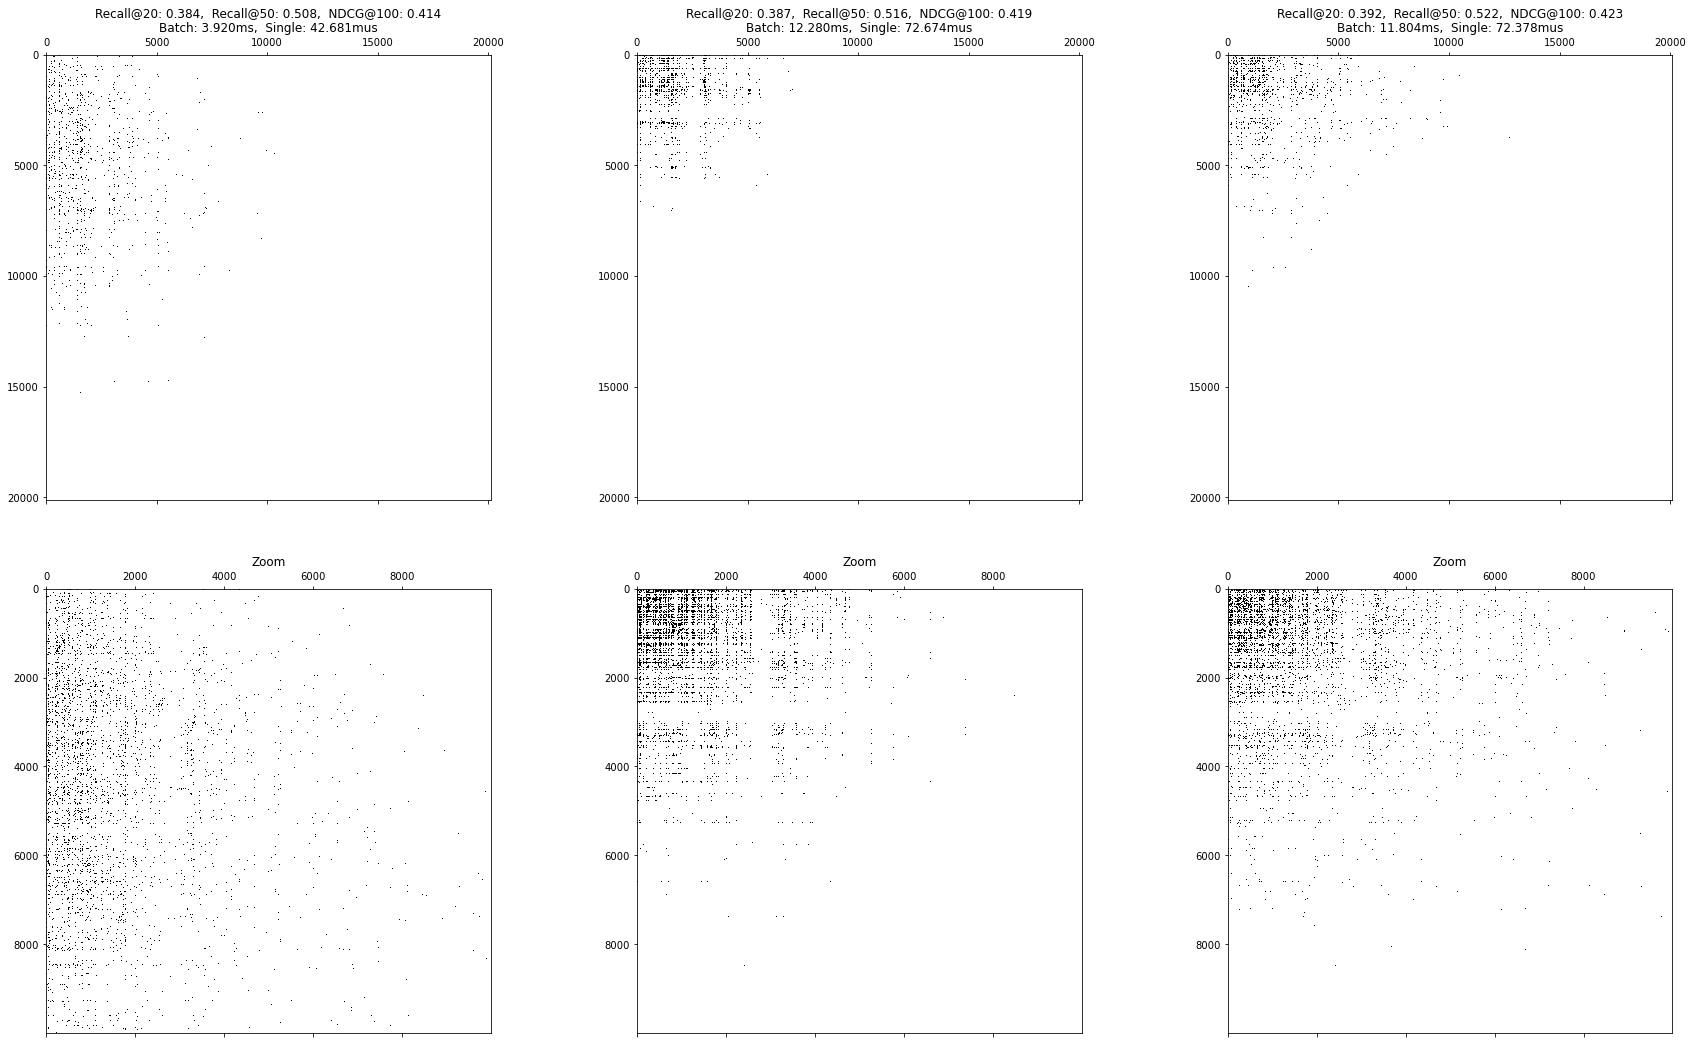

In [34]:
fig, ax = plt.subplots(2,3, figsize=(30,18))
ax[0,0].spy(B_straightforward)
ax[0,0].set_title(f'Recall@20: {metr_EDLAE_straight["Recall(k=20)"]:.3f},  Recall@50: {metr_EDLAE_straight["Recall(k=50)"]:.3f},  NDCG@100: {metr_EDLAE_straight["NDCG(k=100)"]:.3f}\n' + 
                  f'Batch: {times_straightforward[0] * 1e3:.3f}ms,  Single: {times_straightforward[1] * 1e6:.3f}mus')
ax[0,1].spy(B_cov)
ax[0,1].set_title(f'Recall@20: {metr_EDLAE_cov["Recall(k=20)"]:.3f},  Recall@50: {metr_EDLAE_cov["Recall(k=50)"]:.3f},  NDCG@100: {metr_EDLAE_cov["NDCG(k=100)"]:.3f}\n' + 
                  f'Batch: {times_cov[0] * 1e3:.3f}ms,  Single: {times_cov[1] * 1e6:.3f}mus')
ax[0,2].spy(B_admm)
ax[0,2].set_title(f'Recall@20: {metr_EDLAE_admm["Recall(k=20)"]:.3f},  Recall@50: {metr_EDLAE_admm["Recall(k=50)"]:.3f},  NDCG@100: {metr_EDLAE_admm["NDCG(k=100)"]:.3f}\n' + 
                  f'Batch: {times_admm[0] * 1e3:.3f}ms,  Single: {times_admm[1] * 1e6:.3f}mus')
ax[1,0].spy(B_straightforward[:10000, :10000])
ax[1,0].set_title('Zoom')
ax[1,1].spy(B_cov[:10000, :10000])
ax[1,1].set_title('Zoom')
ax[1,2].spy(B_admm[:10000, :10000])
ax[1,2].set_title('Zoom')

#### Sparsity 0.1%

In [35]:
results_straightf_ml20m = pd.read_csv('/home/pmoritz/dev/modsem/benchmarks/ml20m_sparse_straightforward_new.csv', sep='|')
results_sparsecov_ml20m = pd.read_csv('/home/pmoritz/dev/modsem/benchmarks/ml20m_sparse_cov_new.csv', sep='|')

In [36]:
results_straightf_ml20m

,sparsity,threshold,query_time,batch_time,recall@20,recall@50,ndcg@100
0,0.000996,0.01220,0.000038,0.002182,0.371671,0.493390,0.402077
1,0.004983,0.00704,0.000043,0.003903,0.384487,0.508046,0.413661
2,0.009973,0.00522,0.000049,0.005279,0.388080,0.513011,0.417549
3,0.019977,0.00366,0.000054,0.007732,0.390239,0.518839,0.420696
4,0.049847,0.00208,0.000077,0.013323,0.391565,0.522446,0.423361


In [37]:
results_sparsecov_ml20m

,sparsity,threshold,alphas,query_time,batch_time,recall@20,recall@50,ndcg@100
0,0.000999,6.58,0.50,0.000050,0.005312,0.375140,0.493187,0.401118
1,0.004980,2.64,0.50,0.000071,0.012431,0.387308,0.515931,0.418530
2,0.010000,9.23,0.25,0.000096,0.019320,0.390200,0.520014,0.421193
3,0.019968,4.73,0.25,0.000124,0.028070,0.391896,0.522009,0.422832
4,0.049844,1.69,0.25,0.000200,0.045912,0.392272,0.522881,0.423813


In [38]:
A_straightforward = sparsify(B_dense, threshold=0.01220, max_in_col=20108)
B_straightforward = np.zeros(B_dense.shape, dtype=np.float32)
B_straightforward[A_straightforward.nonzero()] = B_dense[A_straightforward.nonzero()]

Number of items with more than 20108 entries in column: 0
Resulting sparsity of A: 0.000995952174549456


In [39]:
model_EDLAE.B = B_straightforward
metr_EDLAE_straight = model_EDLAE.evaluate_metrics(test_tr_ML20M, test_te_ML20M, 'uid', 'sid', metrics_lst)
print(f'My EDLAE:  Recall@20: {metr_EDLAE_straight["Recall(k=20)"]:.8f}, Recall@50: {metr_EDLAE_straight["Recall(k=50)"]:.8f}, NDCG@100: {metr_EDLAE_straight["NDCG(k=100)"]:.8f}')

create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
My EDLAE:  Recall@20: 0.37167060, Recall@50: 0.49339041, NDCG@100: 0.40207703


In [40]:
times_straightforward = timeit_sparse(sp.csr_matrix(B_straightforward), X_test=X_test_tr_ML20M, n_users_test=X_test_tr_ML20M.shape[0], max_k = 100, n_jobs=16)

In [41]:
A_sparsecov = sparsity_pattern_cov(XtX=np.dot(X_train_ML20M.T, X_train_ML20M).toarray(), n_users=X_train_ML20M.shape[0], 
                                 max_in_col=20108, alpha=0.50, threshold=6.58)
B_cov = np.zeros(B_dense.shape, dtype=np.float32)
B_cov[A_sparsecov.nonzero()] = B_dense[A_sparsecov.nonzero()]

Number of items with more than 20108 entries in column: 0
Resulting sparsity of A: 0.0009986652937475607


In [42]:
model_EDLAE.B = B_cov
metr_EDLAE_cov = model_EDLAE.evaluate_metrics(test_tr_ML20M, test_te_ML20M, 'uid', 'sid', metrics_lst)
print(f'My EDLAE:  Recall@20: {metr_EDLAE_cov["Recall(k=20)"]:.8f}, Recall@50: {metr_EDLAE_cov["Recall(k=50)"]:.8f}, NDCG@100: {metr_EDLAE_cov["NDCG(k=100)"]:.8f}')

create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
My EDLAE:  Recall@20: 0.37513973, Recall@50: 0.49318726, NDCG@100: 0.40111827


In [43]:
times_cov = timeit_sparse(sp.csr_matrix(B_cov), X_test=X_test_tr_ML20M, n_users_test=X_test_tr_ML20M.shape[0], max_k = 100, n_jobs=16)

In [44]:
B_admm = np.load(file='/home/pmoritz/dev/modsem/sparse_mat/' + 'ADMM_ml20m_01.npy')

In [45]:
model_EDLAE.B = B_admm
metr_EDLAE_admm = model_EDLAE.evaluate_metrics(test_tr_ML20M, test_te_ML20M, 'uid', 'sid', metrics_lst)
print(f'My EDLAE:  Recall@20: {metr_EDLAE_admm["Recall(k=20)"]:.8f}, Recall@50: {metr_EDLAE_admm["Recall(k=50)"]:.8f}, NDCG@100: {metr_EDLAE_admm["NDCG(k=100)"]:.8f}')

create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
My EDLAE:  Recall@20: 0.38429537, Recall@50: 0.51179690, NDCG@100: 0.41470931


In [46]:
times_admm = timeit_sparse(sp.csr_matrix(B_admm), X_test=X_test_tr_ML20M, n_users_test=X_test_tr_ML20M.shape[0], max_k = 100, n_jobs=16)

Text(0.5, 1.0, 'Zoom')

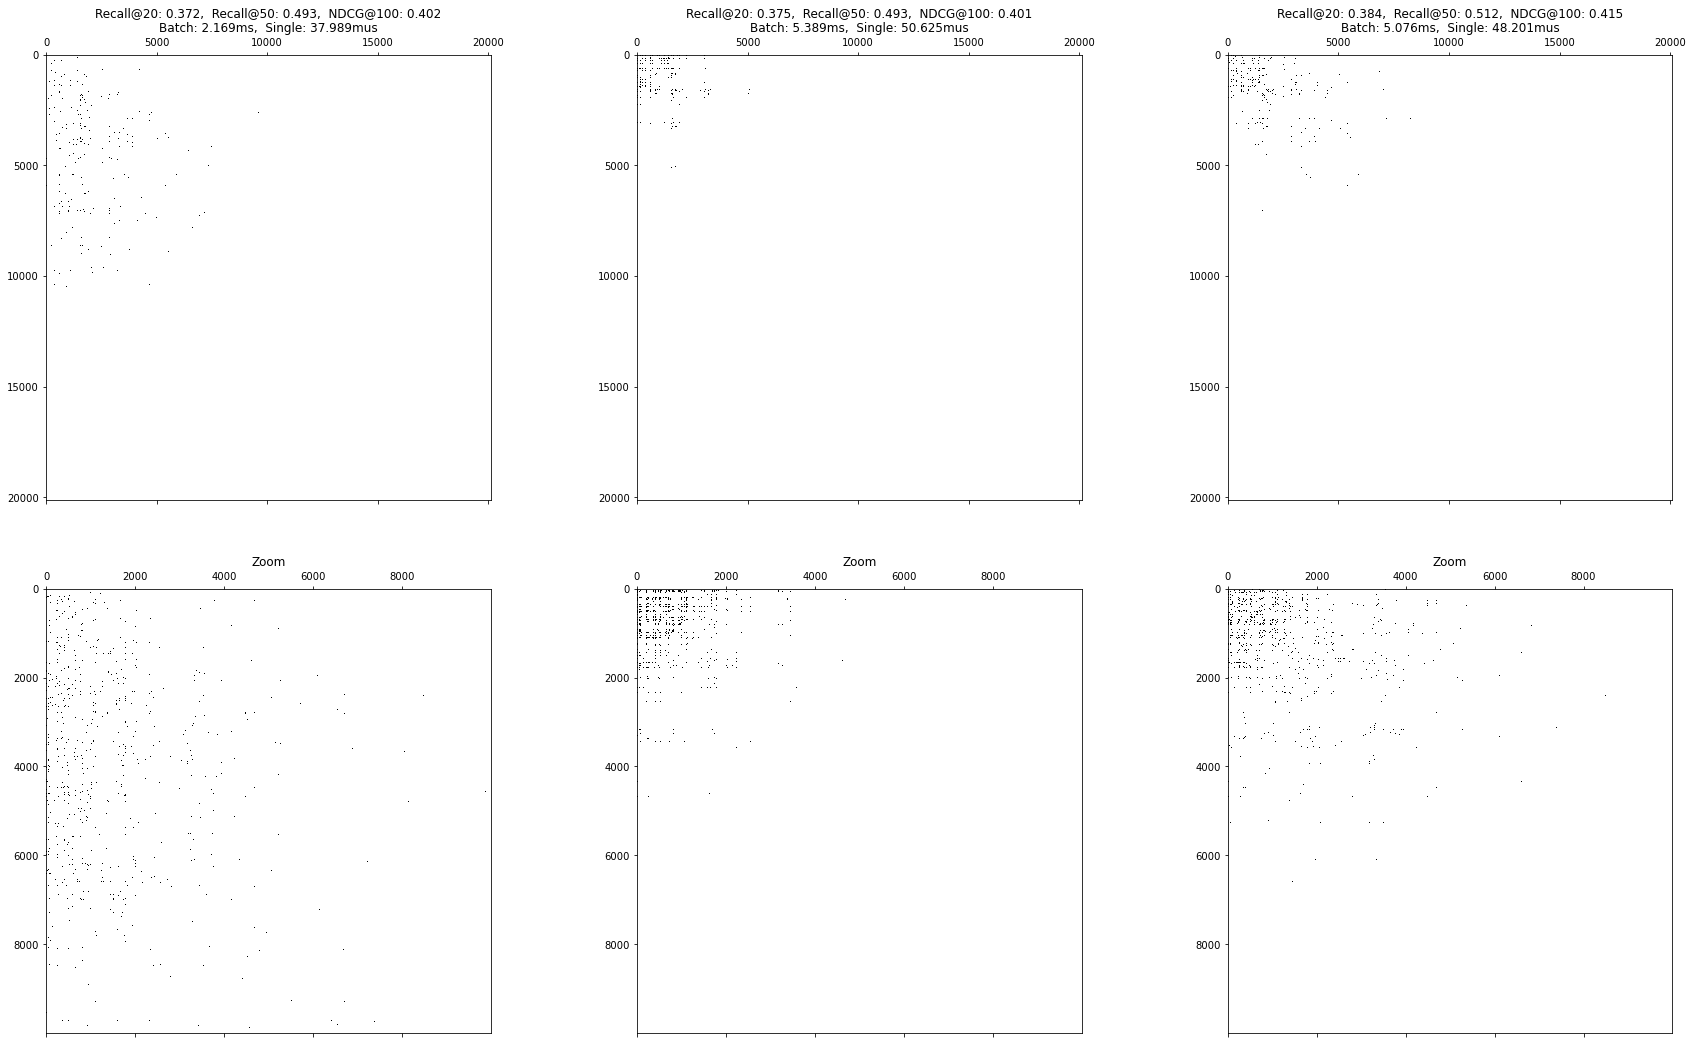

In [48]:
fig, ax = plt.subplots(2,3, figsize=(30,18))
ax[0,0].spy(B_straightforward)
ax[0,0].set_title(f'Recall@20: {metr_EDLAE_straight["Recall(k=20)"]:.3f},  Recall@50: {metr_EDLAE_straight["Recall(k=50)"]:.3f},  NDCG@100: {metr_EDLAE_straight["NDCG(k=100)"]:.3f}\n' + 
                  f'Batch: {times_straightforward[0] * 1e3:.3f}ms,  Single: {times_straightforward[1] * 1e6:.3f}mus')
ax[0,1].spy(B_cov)
ax[0,1].set_title(f'Recall@20: {metr_EDLAE_cov["Recall(k=20)"]:.3f},  Recall@50: {metr_EDLAE_cov["Recall(k=50)"]:.3f},  NDCG@100: {metr_EDLAE_cov["NDCG(k=100)"]:.3f}\n' + 
                  f'Batch: {times_cov[0] * 1e3:.3f}ms,  Single: {times_cov[1] * 1e6:.3f}mus')
ax[0,2].spy(B_admm)
ax[0,2].set_title(f'Recall@20: {metr_EDLAE_admm["Recall(k=20)"]:.3f},  Recall@50: {metr_EDLAE_admm["Recall(k=50)"]:.3f},  NDCG@100: {metr_EDLAE_admm["NDCG(k=100)"]:.3f}\n' + 
                  f'Batch: {times_admm[0] * 1e3:.3f}ms,  Single: {times_admm[1] * 1e6:.3f}mus')
ax[1,0].spy(B_straightforward[:10000, :10000])
ax[1,0].set_title('Zoom')
ax[1,1].spy(B_cov[:10000, :10000])
ax[1,1].set_title('Zoom')
ax[1,2].spy(B_admm[:10000, :10000])
ax[1,2].set_title('Zoom')

### Netflix

In [49]:
model_EDLAE = EDLAE(p=0.33, lmbda=500)
model_EDLAE.fit(train_netflix, uid_str='uid', sid_str='sid', nItems=17769)
metr_EDLAE = model_EDLAE.evaluate_metrics(test_tr_netflix, test_te_netflix, 'uid', 'sid', metrics_lst)
print(f'My DLAE:  Recall@20: {metr_EDLAE["Recall(k=20)"]:.8f}, Recall@50: {metr_EDLAE["Recall(k=50)"]:.8f}, NDCG@100: {metr_EDLAE["NDCG(k=100)"]:.8f}')

finished inverse computation
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
My DLAE:  Recall@20: 0.36553381, Recall@50: 0.44917571, NDCG@100: 0.39768706


In [50]:
B_dense = deepcopy(model_EDLAE.B)

#### Sparsity 0.5%

In [51]:
results_straightf_netflix = pd.read_csv('/home/pmoritz/dev/modsem/benchmarks/netflix_sparse_straightforward_new.csv', sep='|')
results_sparsecov_netflix = pd.read_csv('/home/pmoritz/dev/modsem/benchmarks/netflix_sparse_cov_new.csv', sep='|')

In [52]:
results_straightf_netflix

,sparsity,threshold,query_time,batch_time,recall@20,recall@50,ndcg@100
0,0.000992,0.01290,0.000037,0.002497,0.344885,0.424491,0.376210
1,0.004982,0.00791,0.000041,0.003970,0.352183,0.434613,0.385183
2,0.009968,0.00621,0.000044,0.005168,0.355969,0.438597,0.388261
3,0.019993,0.00467,0.000049,0.006928,0.359929,0.442264,0.391517
4,0.049779,0.00292,0.000061,0.011384,0.363344,0.446394,0.395190


In [53]:
results_sparsecov_netflix

,sparsity,threshold,alphas,query_time,batch_time,recall@20,recall@50,ndcg@100
0,0.001000,2.047,0.75,0.000054,0.005387,0.345687,0.423378,0.375113
1,0.004998,1.096,0.75,0.000087,0.013377,0.359781,0.441876,0.391293
2,0.009985,0.772,0.75,0.000113,0.019967,0.362675,0.445938,0.394816
3,0.019981,0.509,0.75,0.000153,0.029651,0.364439,0.448163,0.396702
4,0.049920,1.764,0.50,0.000265,0.055286,0.365214,0.449104,0.397588


In [54]:
A_straightforward = sparsify(B_dense, threshold=0.00791, max_in_col=17769)
B_straightforward = np.zeros(B_dense.shape, dtype=np.float32)
B_straightforward[A_straightforward.nonzero()] = B_dense[A_straightforward.nonzero()]

Number of items with more than 17769 entries in column: 0
Resulting sparsity of A: 0.004982394212131266


In [55]:
model_EDLAE.B = B_straightforward
metr_EDLAE_straight = model_EDLAE.evaluate_metrics(test_tr_netflix, test_te_netflix, 'uid', 'sid', metrics_lst)
print(f'My EDLAE:  Recall@20: {metr_EDLAE_straight["Recall(k=20)"]:.8f}, Recall@50: {metr_EDLAE_straight["Recall(k=50)"]:.8f}, NDCG@100: {metr_EDLAE_straight["NDCG(k=100)"]:.8f}')

create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
My EDLAE:  Recall@20: 0.35218261, Recall@50: 0.43461337, NDCG@100: 0.38518350


In [56]:
times_straightforward = timeit_sparse(sp.csr_matrix(B_straightforward), X_test=X_test_tr_netflix, n_users_test=X_test_tr_netflix.shape[0], max_k = 100, n_jobs=16)

In [57]:
A_sparsecov = sparsity_pattern_cov(XtX=np.dot(X_train_netflix.T, X_train_netflix).toarray(), n_users=X_train_netflix.shape[0], 
                                 max_in_col=17769, alpha=0.75, threshold=1.096)
B_cov = np.zeros(B_dense.shape, dtype=np.float32)
B_cov[A_sparsecov.nonzero()] = B_dense[A_sparsecov.nonzero()]

Number of items with more than 17769 entries in column: 0
Resulting sparsity of A: 0.004997865931995296


In [58]:
model_EDLAE.B = B_cov
metr_EDLAE_cov = model_EDLAE.evaluate_metrics(test_tr_netflix, test_te_netflix, 'uid', 'sid', metrics_lst)
print(f'My EDLAE:  Recall@20: {metr_EDLAE_cov["Recall(k=20)"]:.8f}, Recall@50: {metr_EDLAE_cov["Recall(k=50)"]:.8f}, NDCG@100: {metr_EDLAE_cov["NDCG(k=100)"]:.8f}')

create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
My EDLAE:  Recall@20: 0.35978085, Recall@50: 0.44187559, NDCG@100: 0.39129279


In [59]:
times_cov = timeit_sparse(sp.csr_matrix(B_cov), X_test=X_test_tr_netflix, n_users_test=X_test_tr_netflix.shape[0], max_k = 100, n_jobs=16)

In [60]:
B_admm = np.load(file='/home/pmoritz/dev/modsem/sparse_mat/' + 'ADMM_netflix_05.npy')

In [61]:
model_EDLAE.B = B_admm
metr_EDLAE_admm = model_EDLAE.evaluate_metrics(test_tr_netflix, test_te_netflix, 'uid', 'sid', metrics_lst)
print(f'My EDLAE:  Recall@20: {metr_EDLAE_admm["Recall(k=20)"]:.8f}, Recall@50: {metr_EDLAE_admm["Recall(k=50)"]:.8f}, NDCG@100: {metr_EDLAE_admm["NDCG(k=100)"]:.8f}')

create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
My EDLAE:  Recall@20: 0.36454960, Recall@50: 0.44807027, NDCG@100: 0.39673890


In [62]:
times_admm = timeit_sparse(sp.csr_matrix(B_admm), X_test=X_test_tr_netflix, n_users_test=X_test_tr_netflix.shape[0], max_k = 100, n_jobs=16)

Text(0.5, 1.0, 'Zoom')

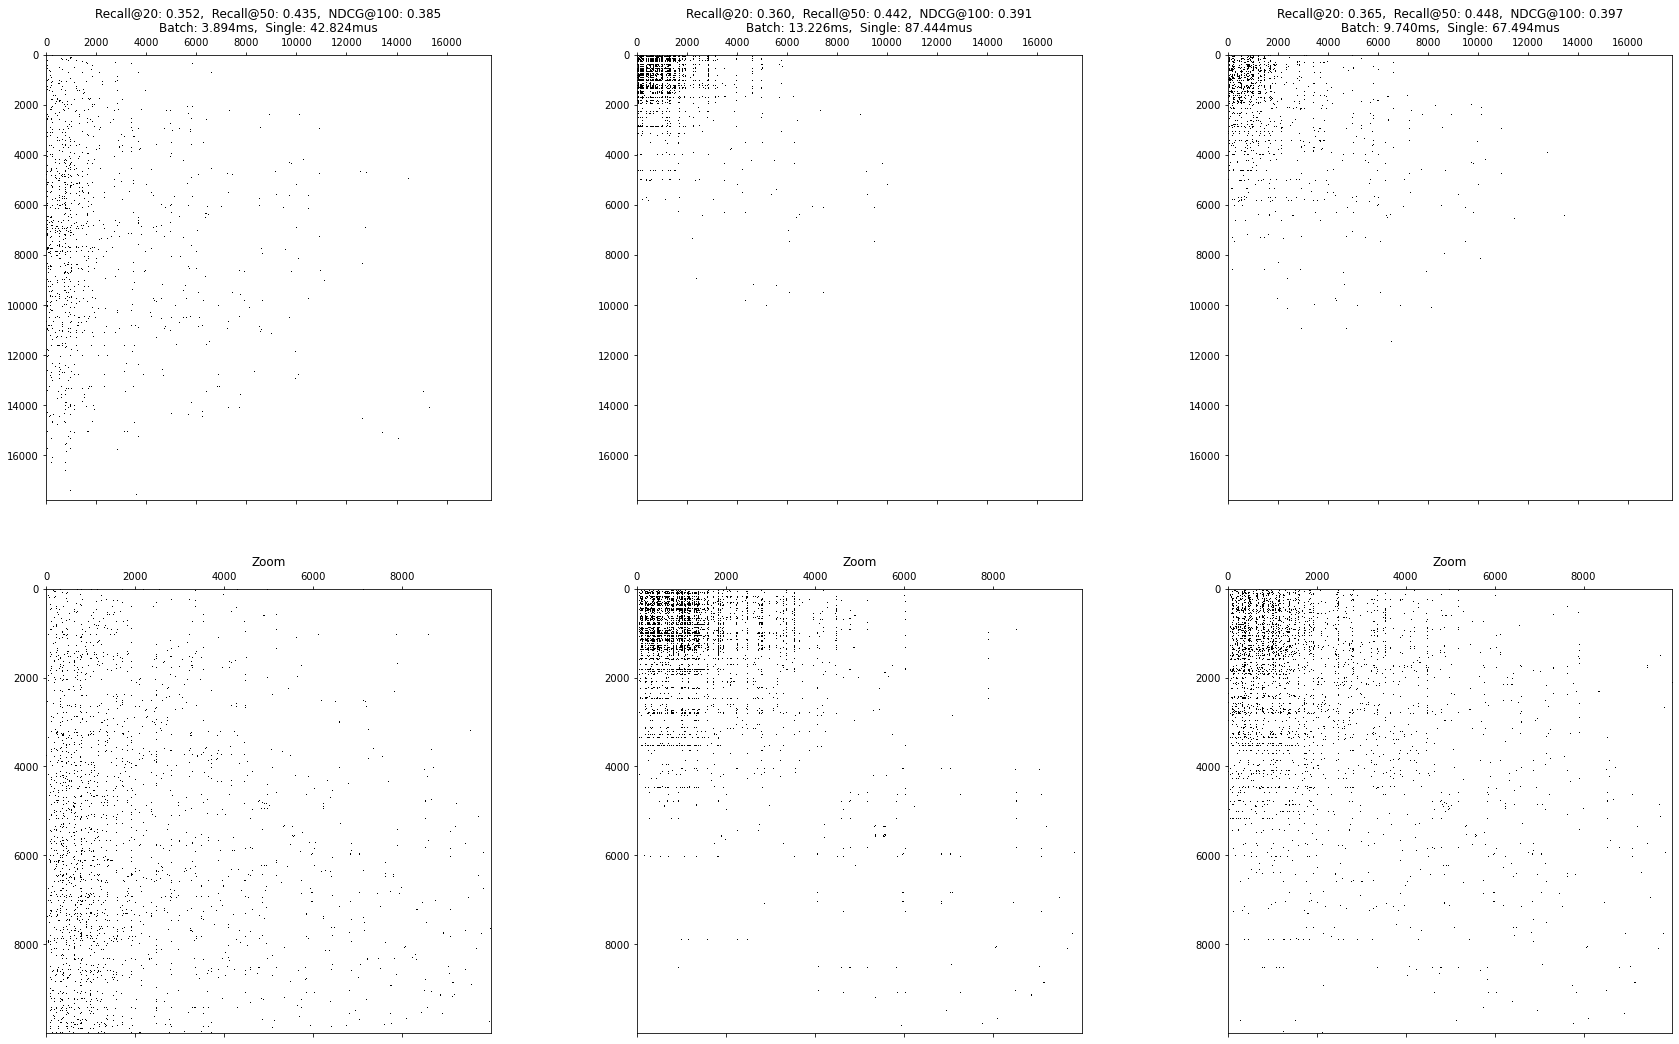

In [63]:
fig, ax = plt.subplots(2,3, figsize=(30,18))
ax[0,0].spy(B_straightforward)
ax[0,0].set_title(f'Recall@20: {metr_EDLAE_straight["Recall(k=20)"]:.3f},  Recall@50: {metr_EDLAE_straight["Recall(k=50)"]:.3f},  NDCG@100: {metr_EDLAE_straight["NDCG(k=100)"]:.3f}\n' + 
                  f'Batch: {times_straightforward[0] * 1e3:.3f}ms,  Single: {times_straightforward[1] * 1e6:.3f}mus')
ax[0,1].spy(B_cov)
ax[0,1].set_title(f'Recall@20: {metr_EDLAE_cov["Recall(k=20)"]:.3f},  Recall@50: {metr_EDLAE_cov["Recall(k=50)"]:.3f},  NDCG@100: {metr_EDLAE_cov["NDCG(k=100)"]:.3f}\n' + 
                  f'Batch: {times_cov[0] * 1e3:.3f}ms,  Single: {times_cov[1] * 1e6:.3f}mus')
ax[0,2].spy(B_admm)
ax[0,2].set_title(f'Recall@20: {metr_EDLAE_admm["Recall(k=20)"]:.3f},  Recall@50: {metr_EDLAE_admm["Recall(k=50)"]:.3f},  NDCG@100: {metr_EDLAE_admm["NDCG(k=100)"]:.3f}\n' + 
                  f'Batch: {times_admm[0] * 1e3:.3f}ms,  Single: {times_admm[1] * 1e6:.3f}mus')
ax[1,0].spy(B_straightforward[:10000, :10000])
ax[1,0].set_title('Zoom')
ax[1,1].spy(B_cov[:10000, :10000])
ax[1,1].set_title('Zoom')
ax[1,2].spy(B_admm[:10000, :10000])
ax[1,2].set_title('Zoom')

#### Sparsity 0.1%

In [64]:
results_straightf_netflix = pd.read_csv('/home/pmoritz/dev/modsem/benchmarks/netflix_sparse_straightforward_new.csv', sep='|')
results_sparsecov_netflix = pd.read_csv('/home/pmoritz/dev/modsem/benchmarks/netflix_sparse_cov_new.csv', sep='|')

In [65]:
results_straightf_netflix

,sparsity,threshold,query_time,batch_time,recall@20,recall@50,ndcg@100
0,0.000992,0.01290,0.000037,0.002497,0.344885,0.424491,0.376210
1,0.004982,0.00791,0.000041,0.003970,0.352183,0.434613,0.385183
2,0.009968,0.00621,0.000044,0.005168,0.355969,0.438597,0.388261
3,0.019993,0.00467,0.000049,0.006928,0.359929,0.442264,0.391517
4,0.049779,0.00292,0.000061,0.011384,0.363344,0.446394,0.395190


In [66]:
results_sparsecov_netflix

,sparsity,threshold,alphas,query_time,batch_time,recall@20,recall@50,ndcg@100
0,0.001000,2.047,0.75,0.000054,0.005387,0.345687,0.423378,0.375113
1,0.004998,1.096,0.75,0.000087,0.013377,0.359781,0.441876,0.391293
2,0.009985,0.772,0.75,0.000113,0.019967,0.362675,0.445938,0.394816
3,0.019981,0.509,0.75,0.000153,0.029651,0.364439,0.448163,0.396702
4,0.049920,1.764,0.50,0.000265,0.055286,0.365214,0.449104,0.397588


In [67]:
A_straightforward = sparsify(B_dense, threshold=0.01290, max_in_col=17769)
B_straightforward = np.zeros(B_dense.shape, dtype=np.float32)
B_straightforward[A_straightforward.nonzero()] = B_dense[A_straightforward.nonzero()]

Number of items with more than 17769 entries in column: 0
Resulting sparsity of A: 0.000991643811199144


In [68]:
model_EDLAE.B = B_straightforward
metr_EDLAE_straight = model_EDLAE.evaluate_metrics(test_tr_netflix, test_te_netflix, 'uid', 'sid', metrics_lst)
print(f'My EDLAE:  Recall@20: {metr_EDLAE_straight["Recall(k=20)"]:.8f}, Recall@50: {metr_EDLAE_straight["Recall(k=50)"]:.8f}, NDCG@100: {metr_EDLAE_straight["NDCG(k=100)"]:.8f}')

create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
My EDLAE:  Recall@20: 0.34488452, Recall@50: 0.42449097, NDCG@100: 0.37621037


In [69]:
times_straightforward = timeit_sparse(sp.csr_matrix(B_straightforward), X_test=X_test_tr_netflix, n_users_test=X_test_tr_netflix.shape[0], max_k = 100, n_jobs=16)

In [70]:
A_sparsecov = sparsity_pattern_cov(XtX=np.dot(X_train_netflix.T, X_train_netflix).toarray(), n_users=X_train_netflix.shape[0], 
                                 max_in_col=17769, alpha=0.75, threshold=2.047)
B_cov = np.zeros(B_dense.shape, dtype=np.float32)
B_cov[A_sparsecov.nonzero()] = B_dense[A_sparsecov.nonzero()]

Number of items with more than 17769 entries in column: 0
Resulting sparsity of A: 0.000999688472090574


In [71]:
model_EDLAE.B = B_cov
metr_EDLAE_cov = model_EDLAE.evaluate_metrics(test_tr_netflix, test_te_netflix, 'uid', 'sid', metrics_lst)
print(f'My EDLAE:  Recall@20: {metr_EDLAE_cov["Recall(k=20)"]:.8f}, Recall@50: {metr_EDLAE_cov["Recall(k=50)"]:.8f}, NDCG@100: {metr_EDLAE_cov["NDCG(k=100)"]:.8f}')

create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
My EDLAE:  Recall@20: 0.34568683, Recall@50: 0.42337809, NDCG@100: 0.37511258


In [72]:
times_cov = timeit_sparse(sp.csr_matrix(B_cov), X_test=X_test_tr_netflix, n_users_test=X_test_tr_netflix.shape[0], max_k = 100, n_jobs=16)

In [73]:
B_admm = np.load(file='/home/pmoritz/dev/modsem/sparse_mat/' + 'ADMM_netflix_01.npy')

In [74]:
model_EDLAE.B = B_admm
metr_EDLAE_admm = model_EDLAE.evaluate_metrics(test_tr_netflix, test_te_netflix, 'uid', 'sid', metrics_lst)
print(f'My EDLAE:  Recall@20: {metr_EDLAE_admm["Recall(k=20)"]:.8f}, Recall@50: {metr_EDLAE_admm["Recall(k=50)"]:.8f}, NDCG@100: {metr_EDLAE_admm["NDCG(k=100)"]:.8f}')

create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
My EDLAE:  Recall@20: 0.35559922, Recall@50: 0.43775692, NDCG@100: 0.38712491


In [75]:
times_admm = timeit_sparse(sp.csr_matrix(B_admm), X_test=X_test_tr_netflix, n_users_test=X_test_tr_netflix.shape[0], max_k = 100, n_jobs=16)

Text(0.5, 1.0, 'Zoom')

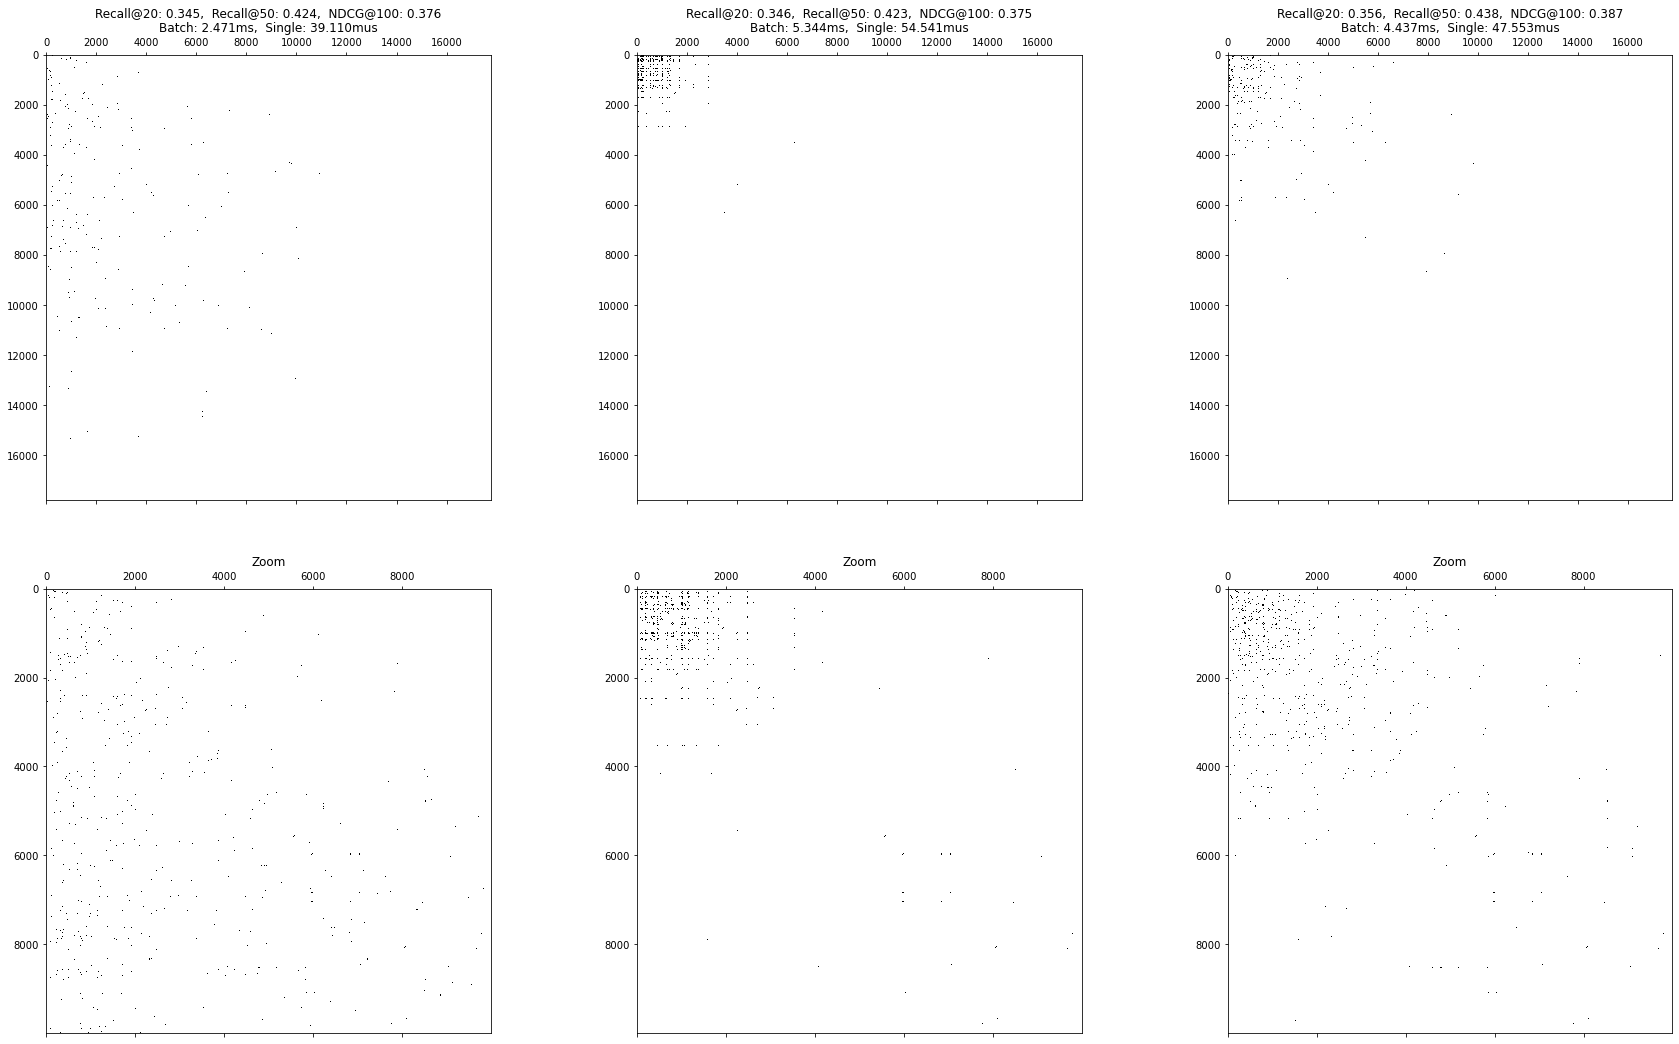

In [76]:
fig, ax = plt.subplots(2,3, figsize=(30,18))
ax[0,0].spy(B_straightforward)
ax[0,0].set_title(f'Recall@20: {metr_EDLAE_straight["Recall(k=20)"]:.3f},  Recall@50: {metr_EDLAE_straight["Recall(k=50)"]:.3f},  NDCG@100: {metr_EDLAE_straight["NDCG(k=100)"]:.3f}\n' + 
                  f'Batch: {times_straightforward[0] * 1e3:.3f}ms,  Single: {times_straightforward[1] * 1e6:.3f}mus')
ax[0,1].spy(B_cov)
ax[0,1].set_title(f'Recall@20: {metr_EDLAE_cov["Recall(k=20)"]:.3f},  Recall@50: {metr_EDLAE_cov["Recall(k=50)"]:.3f},  NDCG@100: {metr_EDLAE_cov["NDCG(k=100)"]:.3f}\n' + 
                  f'Batch: {times_cov[0] * 1e3:.3f}ms,  Single: {times_cov[1] * 1e6:.3f}mus')
ax[0,2].spy(B_admm)
ax[0,2].set_title(f'Recall@20: {metr_EDLAE_admm["Recall(k=20)"]:.3f},  Recall@50: {metr_EDLAE_admm["Recall(k=50)"]:.3f},  NDCG@100: {metr_EDLAE_admm["NDCG(k=100)"]:.3f}\n' + 
                  f'Batch: {times_admm[0] * 1e3:.3f}ms,  Single: {times_admm[1] * 1e6:.3f}mus')
ax[1,0].spy(B_straightforward[:10000, :10000])
ax[1,0].set_title('Zoom')
ax[1,1].spy(B_cov[:10000, :10000])
ax[1,1].set_title('Zoom')
ax[1,2].spy(B_admm[:10000, :10000])
ax[1,2].set_title('Zoom')

### MSD

In [11]:
model_EDLAE = EDLAE(p=0.25, lmbda=70)
model_EDLAE.fit(train_msd, uid_str='uid', sid_str='sid', nItems=41140)
metr_EDLAE = model_EDLAE.evaluate_metrics(test_tr_msd, test_te_msd, 'uid', 'sid', metrics_lst)
print(f'My DLAE:  Recall@20: {metr_EDLAE["Recall(k=20)"]:.8f}, Recall@50: {metr_EDLAE["Recall(k=50)"]:.8f}, NDCG@100: {metr_EDLAE["NDCG(k=100)"]:.8f}')

finished inverse computation
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
My DLAE:  Recall@20: 0.33407616, Recall@50: 0.42947739, NDCG@100: 0.39150817


In [17]:
B_dense = deepcopy(model_EDLAE.B)

#### Sparsity 0.5%

In [12]:
results_straightf_msd = pd.read_csv('/home/pmoritz/dev/modsem/benchmarks/msd_sparse_straightforward_new.csv', sep='|')
results_sparsecov_msd = pd.read_csv('/home/pmoritz/dev/modsem/benchmarks/msd_sparse_cov_new.csv', sep='|')

In [13]:
results_straightf_msd

,sparsity,threshold,query_time,batch_time,recall@20,recall@50,ndcg@100
0,0.000996,0.01200,0.000046,0.002143,0.329580,0.421199,0.385550
1,0.004999,0.00695,0.000061,0.005023,0.332307,0.425618,0.388885
2,0.009965,0.00548,0.000084,0.007808,0.332764,0.426840,0.389641
3,0.019911,0.00421,0.000122,0.012880,0.333207,0.427856,0.390281
4,0.049860,0.00285,0.000236,0.025263,0.333736,0.428533,0.390753


In [14]:
results_sparsecov_msd

,sparsity,threshold,alphas,query_time,batch_time,recall@20,recall@50,ndcg@100
0,0.000999,0.37000,0.75,0.000056,0.003136,0.328761,0.419584,0.384312
1,0.004997,0.60900,0.50,0.000156,0.014406,0.333152,0.427825,0.390515
2,0.009994,0.39900,0.50,0.000271,0.024603,0.333532,0.429220,0.391244
3,0.019999,0.05110,0.75,0.000345,0.032637,0.333932,0.429746,0.391716
4,0.049976,0.00644,1.00,0.000490,0.048523,0.334155,0.429881,0.391885


In [18]:
A_straightforward = sparsify(B_dense, threshold=0.00695, max_in_col=41140)
B_straightforward = np.zeros(B_dense.shape, dtype=np.float32)
B_straightforward[A_straightforward.nonzero()] = B_dense[A_straightforward.nonzero()]

Number of items with more than 41140 entries in column: 0
Resulting sparsity of A: 0.004999415657173567


In [19]:
model_EDLAE.B = B_straightforward
metr_EDLAE_straight = model_EDLAE.evaluate_metrics(test_tr_msd, test_te_msd, 'uid', 'sid', metrics_lst)
print(f'My EDLAE:  Recall@20: {metr_EDLAE_straight["Recall(k=20)"]:.8f}, Recall@50: {metr_EDLAE_straight["Recall(k=50)"]:.8f}, NDCG@100: {metr_EDLAE_straight["NDCG(k=100)"]:.8f}')

create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
My EDLAE:  Recall@20: 0.33230736, Recall@50: 0.42561803, NDCG@100: 0.38888537


In [20]:
times_straightforward = timeit_sparse(sp.csr_matrix(B_straightforward), X_test=X_test_tr_msd, n_users_test=X_test_tr_msd.shape[0], max_k = 100, n_jobs=16)

In [21]:
A_sparsecov = sparsity_pattern_cov(XtX=np.dot(X_train_msd.T, X_train_msd).toarray(), n_users=X_train_msd.shape[0], 
                                 max_in_col=41140, alpha=0.5, threshold=0.60900)
B_cov = np.zeros(B_dense.shape, dtype=np.float32)
B_cov[A_sparsecov.nonzero()] = B_dense[A_sparsecov.nonzero()]

Number of items with more than 41140 entries in column: 0
Resulting sparsity of A: 0.00499654889135572


In [22]:
model_EDLAE.B = B_cov
metr_EDLAE_cov = model_EDLAE.evaluate_metrics(test_tr_msd, test_te_msd, 'uid', 'sid', metrics_lst)
print(f'My EDLAE:  Recall@20: {metr_EDLAE_cov["Recall(k=20)"]:.8f}, Recall@50: {metr_EDLAE_cov["Recall(k=50)"]:.8f}, NDCG@100: {metr_EDLAE_cov["NDCG(k=100)"]:.8f}')

create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
My EDLAE:  Recall@20: 0.33315223, Recall@50: 0.42782471, NDCG@100: 0.39051469


In [23]:
times_cov = timeit_sparse(sp.csr_matrix(B_cov), X_test=X_test_tr_msd, n_users_test=X_test_tr_msd.shape[0], max_k = 100, n_jobs=16)

Text(0.5, 1.0, 'Zoom')

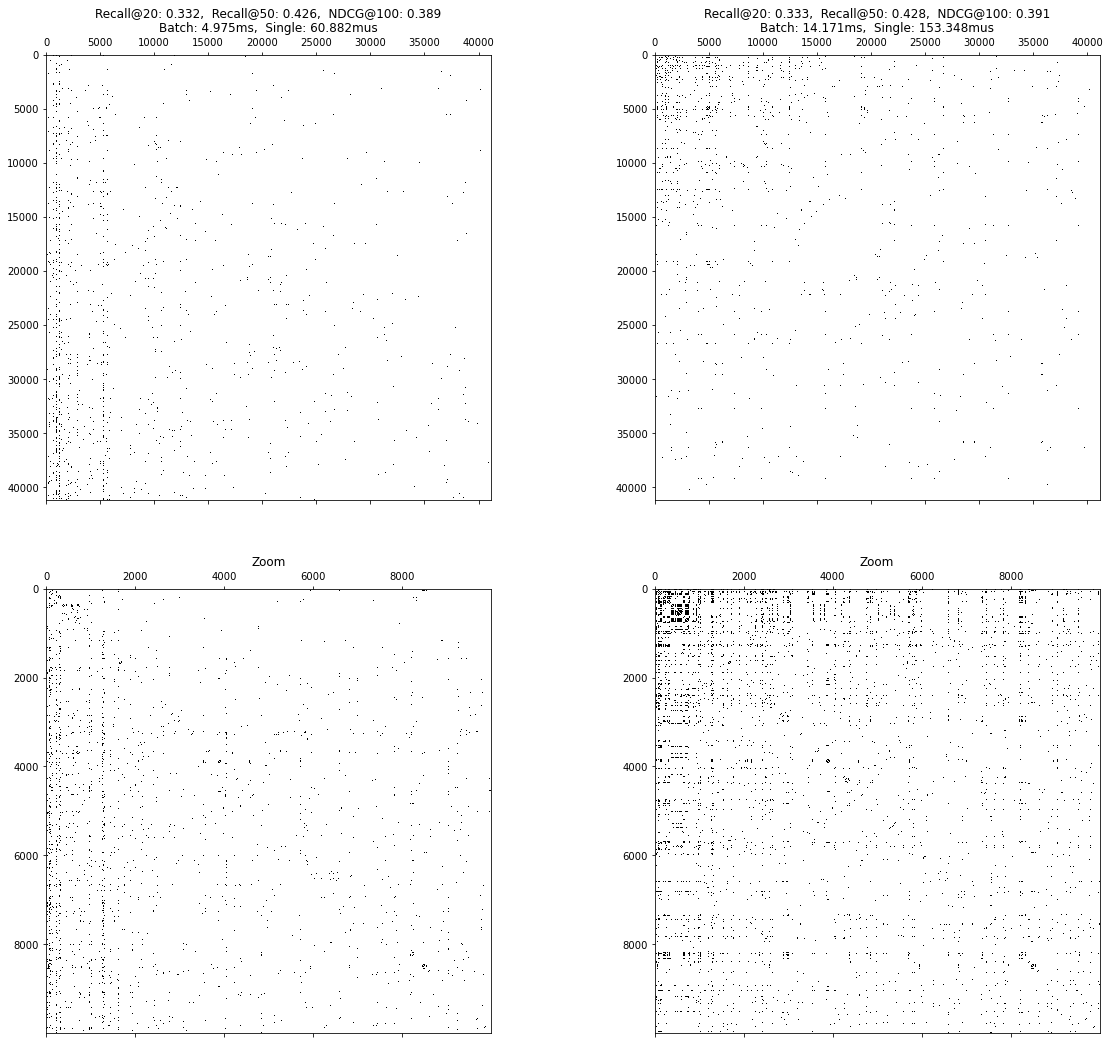

In [24]:
fig, ax = plt.subplots(2,2, figsize=(20,18))
ax[0,0].spy(B_straightforward)
ax[0,0].set_title(f'Recall@20: {metr_EDLAE_straight["Recall(k=20)"]:.3f},  Recall@50: {metr_EDLAE_straight["Recall(k=50)"]:.3f},  NDCG@100: {metr_EDLAE_straight["NDCG(k=100)"]:.3f}\n' + 
                  f'Batch: {times_straightforward[0] * 1e3:.3f}ms,  Single: {times_straightforward[1] * 1e6:.3f}mus')
ax[0,1].spy(B_cov)
ax[0,1].set_title(f'Recall@20: {metr_EDLAE_cov["Recall(k=20)"]:.3f},  Recall@50: {metr_EDLAE_cov["Recall(k=50)"]:.3f},  NDCG@100: {metr_EDLAE_cov["NDCG(k=100)"]:.3f}\n' + 
                  f'Batch: {times_cov[0] * 1e3:.3f}ms,  Single: {times_cov[1] * 1e6:.3f}mus')
ax[1,0].spy(B_straightforward[:10000, :10000])
ax[1,0].set_title('Zoom')
ax[1,1].spy(B_cov[:10000, :10000])
ax[1,1].set_title('Zoom')

#### Sparsity 0.1%

In [25]:
results_straightf_msd = pd.read_csv('/home/pmoritz/dev/modsem/benchmarks/msd_sparse_straightforward_new.csv', sep='|')
results_sparsecov_msd = pd.read_csv('/home/pmoritz/dev/modsem/benchmarks/msd_sparse_cov_new.csv', sep='|')

In [26]:
results_straightf_msd

,sparsity,threshold,query_time,batch_time,recall@20,recall@50,ndcg@100
0,0.000996,0.01200,0.000046,0.002143,0.329580,0.421199,0.385550
1,0.004999,0.00695,0.000061,0.005023,0.332307,0.425618,0.388885
2,0.009965,0.00548,0.000084,0.007808,0.332764,0.426840,0.389641
3,0.019911,0.00421,0.000122,0.012880,0.333207,0.427856,0.390281
4,0.049860,0.00285,0.000236,0.025263,0.333736,0.428533,0.390753


In [27]:
results_sparsecov_msd

,sparsity,threshold,alphas,query_time,batch_time,recall@20,recall@50,ndcg@100
0,0.000999,0.37000,0.75,0.000056,0.003136,0.328761,0.419584,0.384312
1,0.004997,0.60900,0.50,0.000156,0.014406,0.333152,0.427825,0.390515
2,0.009994,0.39900,0.50,0.000271,0.024603,0.333532,0.429220,0.391244
3,0.019999,0.05110,0.75,0.000345,0.032637,0.333932,0.429746,0.391716
4,0.049976,0.00644,1.00,0.000490,0.048523,0.334155,0.429881,0.391885


In [28]:
A_straightforward = sparsify(B_dense, threshold=0.01200, max_in_col=41140)
B_straightforward = np.zeros(B_dense.shape, dtype=np.float32)
B_straightforward[A_straightforward.nonzero()] = B_dense[A_straightforward.nonzero()]

Number of items with more than 41140 entries in column: 0
Resulting sparsity of A: 0.0009962667051738152


In [29]:
model_EDLAE.B = B_straightforward
metr_EDLAE_straight = model_EDLAE.evaluate_metrics(test_tr_msd, test_te_msd, 'uid', 'sid', metrics_lst)
print(f'My EDLAE:  Recall@20: {metr_EDLAE_straight["Recall(k=20)"]:.8f}, Recall@50: {metr_EDLAE_straight["Recall(k=50)"]:.8f}, NDCG@100: {metr_EDLAE_straight["NDCG(k=100)"]:.8f}')

create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
My EDLAE:  Recall@20: 0.32958039, Recall@50: 0.42119861, NDCG@100: 0.38554988


In [30]:
times_straightforward = timeit_sparse(sp.csr_matrix(B_straightforward), X_test=X_test_tr_msd, n_users_test=X_test_tr_msd.shape[0], max_k = 100, n_jobs=16)

In [31]:
A_sparsecov = sparsity_pattern_cov(XtX=np.dot(X_train_msd.T, X_train_msd).toarray(), n_users=X_train_msd.shape[0], 
                                 max_in_col=41140, alpha=0.75, threshold=0.37000)
B_cov = np.zeros(B_dense.shape, dtype=np.float32)
B_cov[A_sparsecov.nonzero()] = B_dense[A_sparsecov.nonzero()]

Number of items with more than 41140 entries in column: 0
Resulting sparsity of A: 0.0009994832495085965


In [32]:
model_EDLAE.B = B_cov
metr_EDLAE_cov = model_EDLAE.evaluate_metrics(test_tr_msd, test_te_msd, 'uid', 'sid', metrics_lst)
print(f'My EDLAE:  Recall@20: {metr_EDLAE_cov["Recall(k=20)"]:.8f}, Recall@50: {metr_EDLAE_cov["Recall(k=50)"]:.8f}, NDCG@100: {metr_EDLAE_cov["NDCG(k=100)"]:.8f}')

create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
My EDLAE:  Recall@20: 0.32876085, Recall@50: 0.41958407, NDCG@100: 0.38431205


In [33]:
times_cov = timeit_sparse(sp.csr_matrix(B_cov), X_test=X_test_tr_msd, n_users_test=X_test_tr_msd.shape[0], max_k = 100, n_jobs=16)

Text(0.5, 1.0, 'Zoom')

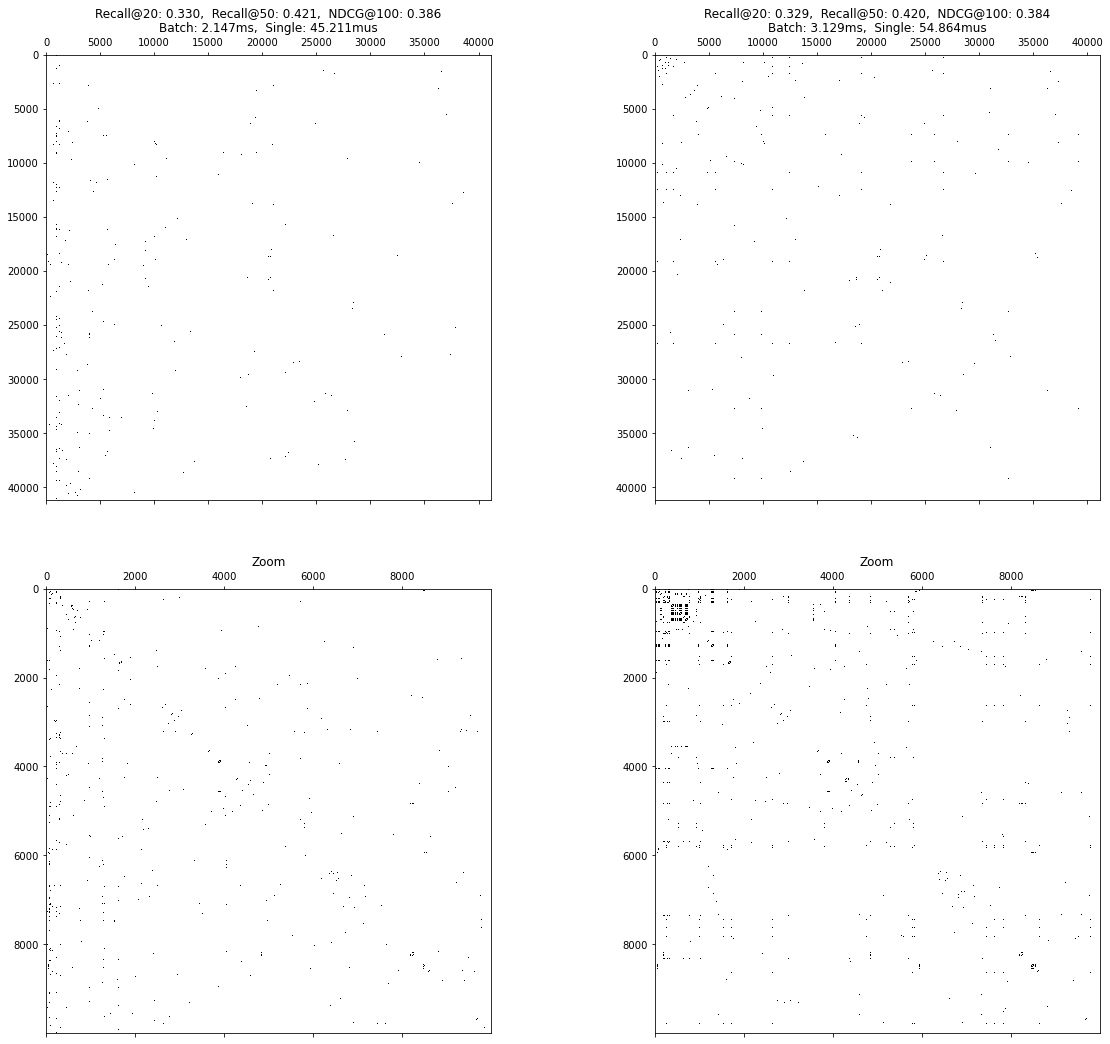

In [34]:
fig, ax = plt.subplots(2,2, figsize=(20,18))
ax[0,0].spy(B_straightforward)
ax[0,0].set_title(f'Recall@20: {metr_EDLAE_straight["Recall(k=20)"]:.3f},  Recall@50: {metr_EDLAE_straight["Recall(k=50)"]:.3f},  NDCG@100: {metr_EDLAE_straight["NDCG(k=100)"]:.3f}\n' + 
                  f'Batch: {times_straightforward[0] * 1e3:.3f}ms,  Single: {times_straightforward[1] * 1e6:.3f}mus')
ax[0,1].spy(B_cov)
ax[0,1].set_title(f'Recall@20: {metr_EDLAE_cov["Recall(k=20)"]:.3f},  Recall@50: {metr_EDLAE_cov["Recall(k=50)"]:.3f},  NDCG@100: {metr_EDLAE_cov["NDCG(k=100)"]:.3f}\n' + 
                  f'Batch: {times_cov[0] * 1e3:.3f}ms,  Single: {times_cov[1] * 1e6:.3f}mus')
ax[1,0].spy(B_straightforward[:10000, :10000])
ax[1,0].set_title('Zoom')
ax[1,1].spy(B_cov[:10000, :10000])
ax[1,1].set_title('Zoom')

## MRF

In [ ]:
def benchnmark_MRF(param_dicts, train, test_tr, test_te, n_items, filename):
    sparsities, alphas, thresholds, rs, lmbdas, max_in_cols = [], [], [], [], [], []
    training_times, batch_times, query_times = [], [], []
    recall20, recall50, ndcg100 = [], [], []
    for param_dict in param_dicts:
        sparsity, alpha, threshold, = param_dict['sparsity'], param_dict['alpha'], param_dict['threshold']
        r, lmbda, max_in_col =  param_dict['r'], param_dict['lambda'], param_dict['max_in_col']
        model_MRF = MRFApprox(lmbda=lmbda)

        def fit_wrapper():
            model_MRF.fit(train, uid_str='uid', sid_str='sid', nItems=n_items, alpha=alpha,threshold=threshold, max_in_col=max_in_col, r=r)

        timer = timeit.Timer(fit_wrapper)
        n_timer, _ = timer.autorange()
        training_time = min(timer.repeat(repeat=7, number=n_timer)) / n_timer

        metrics_lst = ['Recall(k=20)', 'Recall(k=50)', 'NDCG(k=100)',]
        metr_EDLAE = model_MRF.evaluate_metrics(test_tr, test_te, 'uid', 'sid', metrics_lst)
        
        calc_sparsity = len(model_MRF.B.nonzero()[0]) / (model_MRF.B.shape[0] * model_MRF.B.shape[1])

        batch_time, query_time = timeit_sparse(model_sparse = model_MRF.B, 
                                               X_test = model_MRF.X_test, 
                                               n_users_test = model_MRF.X_test.shape[0], max_k = 100)

        sparsities.append(calc_sparsity)
        alphas.append(alpha)
        thresholds.append(threshold)
        rs.append(r)
        lmbdas.append(lmbda)
        max_in_cols.append(max_in_col)
        training_times.append(training_time )
        batch_times.append(batch_time)
        query_times.append(query_time)
        recall20.append(metr_EDLAE["Recall(k=20)"])
        recall50.append(metr_EDLAE["Recall(k=50)"])
        ndcg100.append(metr_EDLAE["NDCG(k=100)"])

    results = pd.DataFrame({'sparsity': sparsities,
                            'alpha': alphas,
                            'threshold': thresholds,
                            'r': rs,
                            'lambda': lmbdas,
                            'max_in_col': max_in_cols,
                            'training_time': training_times,
                            'query_time': query_times, 
                            'batch_time': batch_times,
                            'recall@20': recall20,
                            'recall@50': recall50,
                            'ndcg@100': ndcg100,})
    results.to_csv(f'benchmarks/{filename}', index=False, sep='|')  

### ML20M

### Netflix

### MSD

## Variational Autoencoder - RecVae
Matches the results from the paper. Might be improved by further hyperparam optimization. Seems like they optimized the model for ML20M and then just changed the gamma param.

In [12]:
import torch
import sys

from RecVAE.model import VAE

In [13]:
def generate(batch_size, device, data_in, data_out=None, shuffle=False, samples_perc_per_epoch=1):
    assert 0 < samples_perc_per_epoch <= 1
    
    total_samples = data_in.shape[0]
    samples_per_epoch = int(total_samples * samples_perc_per_epoch)
    
    if shuffle:
        idxlist = np.arange(total_samples)
        np.random.shuffle(idxlist)
        idxlist = idxlist[:samples_per_epoch]
    else:
        idxlist = np.arange(samples_per_epoch)
    
    for st_idx in range(0, samples_per_epoch, batch_size):
        end_idx = min(st_idx + batch_size, samples_per_epoch)
        idx = idxlist[st_idx:end_idx]

        yield Batch(device, idx, data_in, data_out)

class Batch:
    def __init__(self, device, idx, data_in, data_out=None):
        self._device = device
        self._idx = idx
        self._data_in = data_in
        self._data_out = data_out
    
    def get_idx(self):
        return self._idx
    
    def get_idx_to_dev(self):
        return torch.LongTensor(self.get_idx()).to(self._device)
        
    def get_ratings(self, is_out=False):
        data = self._data_out if is_out else self._data_in
        return data[self._idx]
    
    def get_ratings_to_dev(self, is_out=False):
        return torch.Tensor(
            self.get_ratings(is_out).toarray()
        ).to(self._device)

def evaluate_VAE(model, data_in, data_out, device, metrics_lst = ['Recall(k=20)', 'Recall(k=50)', 'NDCG(k=100)',], samples_perc_per_epoch=1, batch_size=500):
    model.to(device)
    model.eval()
    metric_callers = {}
    scores = {}
    max_topk = 0
    for metric in metrics_lst:
        try:
            metric_callers[metric] = eval(metric)
            max_topk = max(max_topk, int(metric.split("k=")[-1].strip(")")))
            scores[metric] = []
        except:
            raise NotImplementedError('metrics={} not implemented.'.format(metric))
    
    for batch in generate(batch_size=batch_size,
                          device=device,
                          data_in=data_in,
                          data_out=data_out,
                          samples_perc_per_epoch=samples_perc_per_epoch
                         ):
        
        ratings_in = batch.get_ratings_to_dev()
        ratings_out = batch.get_ratings(is_out=True)
    
        ratings_pred = model(ratings_in, calculate_loss=False).cpu().detach().numpy()
                
        if not (data_in is data_out):
            ratings_pred[batch.get_ratings().nonzero()] = -np.inf
            
        
        topk = argpartition(-ratings_pred, max_topk - 1, axis=1)[:, :max_topk]

        # we need to sort manually
        n_batch = ratings_out.shape[0]
        sorted_idx = (-ratings_pred)[np.arange(n_batch)[:, None], topk].argsort()
        topk = topk[np.arange(n_batch)[:, None], sorted_idx]
        
        for row in range(ratings_out.shape[0]):
            pred_items = topk[row, :]
            ratings_out_row  = ratings_out[row, :]
            _, true_items, _ = sp.find(ratings_out_row)
            
            for metric in metrics_lst:
                scores[metric].append(metric_callers[metric](pred_items, true_items))

    for metric in scores.keys():
        scores[metric] = np.mean(scores[metric])
        
    return scores

### ML20M

In [14]:
model_kwargs = {
    'hidden_dim': 600,
    'latent_dim': 200,
    'input_dim': 20108
}

In [15]:
model_best = VAE(**model_kwargs)
model_best.load_state_dict(torch.load('RecVAE/ml20m_best'))

<All keys matched successfully>

In [16]:
gpu = torch.device("cuda:0")

In [17]:
evaluate_VAE(model=model_best, 
             data_in=X_test_tr_ML20M, 
             data_out=X_test_te_ML20M, 
             device=gpu, #='cpu',
             metrics_lst = ['Recall(k=20)', 'Recall(k=50)', 'NDCG(k=100)',], 
             samples_perc_per_epoch=1, 
             batch_size=500)

{'Recall(k=20)': 0.41422593409041947,
 'Recall(k=50)': 0.554342493936054,
 'NDCG(k=100)': 0.44284833890062303}

#### GPU Times

In [18]:
timeit_dense_VAE(model_best, 
                 device=gpu, 
                 X_test_tr=X_test_tr_ML20M, 
                 n_users_test=X_test_tr_ML20M.shape[0], 
                 max_k = 100)

(0.007976332239923067, 0.0005040700495999772)

#### CPU Times

In [19]:
timeit_dense_VAE(model_best, 
                 device='cpu', 
                 X_test_tr=X_test_tr_ML20M, 
                 n_users_test=X_test_tr_ML20M.shape[0], 
                 max_k = 100)

(0.06844658839982003, 0.0013716692335001427)

### Netflix

In [20]:
model_kwargs = {
    'hidden_dim': 600,
    'latent_dim': 200,
    'input_dim': 17769
}

In [21]:
model_best = VAE(**model_kwargs)
model_best.load_state_dict(torch.load('RecVAE/netflix_best'))

<All keys matched successfully>

In [22]:
gpu = torch.device("cuda:0")

In [23]:
evaluate_VAE(model=model_best, 
             data_in=X_test_tr_netflix, 
             data_out=X_test_te_netflix, 
             device=gpu, #='cpu',
             metrics_lst = ['Recall(k=20)', 'Recall(k=50)', 'NDCG(k=100)',], 
             samples_perc_per_epoch=1, 
             batch_size=500)

{'Recall(k=20)': 0.36266024174140277,
 'Recall(k=50)': 0.4533128744640806,
 'NDCG(k=100)': 0.39479793227199245}

#### GPU Times

In [24]:
timeit_dense_VAE(model_best, 
                 device=gpu, 
                 X_test_tr=X_test_tr_netflix, 
                 n_users_test=X_test_tr_netflix.shape[0], 
                 max_k = 100)

(0.006986608479928691, 0.0004566206084011356)

#### CPU Times

In [25]:
timeit_dense_VAE(model_best, 
                 device='cpu', 
                 X_test_tr=X_test_tr_netflix, 
                 n_users_test=X_test_tr_netflix.shape[0], 
                 max_k = 100)

(0.06142326380067971, 0.001217555672985327)

### MSD

In [26]:
model_kwargs = {
    'hidden_dim': 600,
    'latent_dim': 200,
    'input_dim': 41140
}

In [27]:
model_best = VAE(**model_kwargs)
model_best.load_state_dict(torch.load('RecVAE/msd_best'))

<All keys matched successfully>

In [28]:
gpu = torch.device("cuda:0")

In [29]:
evaluate_VAE(model=model_best, 
             data_in=X_test_tr_msd, 
             data_out=X_test_te_msd, 
             device=gpu, #='cpu',
             metrics_lst = ['Recall(k=20)', 'Recall(k=50)', 'NDCG(k=100)',], 
             samples_perc_per_epoch=1, 
             batch_size=500)

{'Recall(k=20)': 0.27711796495266,
 'Recall(k=50)': 0.37538190093131724,
 'NDCG(k=100)': 0.32709714843412047}

Matches results from the paper. Might be improved by further hyperparam optimization. Seems like they optimized the model for ML20M and then just changed the gamma param.

#### GPU Times

In [30]:
timeit_dense_VAE(model_best, 
                 device=gpu, 
                 X_test_tr=X_test_tr_msd, 
                 n_users_test=X_test_tr_msd.shape[0], 
                 max_k = 100)

(0.024473337250674375, 0.00048650301440211476)

#### CPU Times

In [31]:
timeit_dense_VAE(model_best, 
                 device='cpu', 
                 X_test_tr=X_test_tr_msd, 
                 n_users_test=X_test_tr_msd.shape[0], 
                 max_k = 100)

(0.13757240600534715, 0.003775026771982084)